#### Laurent Jutras-Dubé

## Model for Tribolium segmentation

####     


**1. Patterning of the antero-posterior (AP) axis in the Tribolium beetle**

In this notebook, we perform simulations of the model for Tribolium segmentation. See the Methods and the Supplement for a description of the model. This model implements a "speed gradient", where the spedd of traveling waves of gap genes from posterior to anterior depends on the level of the morphogen, $caudal$ ($cad$). This leads to robust patterning of the embryo. This model was proposed in the following paper:

Xin Zhu, Heike Rudolf, Lucas Healey, Paul François, Susan J Brown, Martin Klingler, and Ezzat El-Sherif. Speed regulation of genetic cascades allows for evolvability in the body plan specification of insects. *Proceedings of the National Academy of Sciences*, 114(41):E8646–E8655, 2017.

In [1]:
%matplotlib notebook
import numpy as np
from scipy.integrate import ode
import matplotlib.pyplot as plt
from matplotlib import colors
plt.rcParams.update({'figure.max_open_warning': 0})

####     

**1.1 The ODEs**

In the following code cell, we define functions for the ODEs describing the dynamics of the 5 proteins, $hb$, $Kr$, $mlpt$, $gt$, and $X$. The protein production term is divided into a dynamic term that encodes a sequential cascade of protein expression, and a static term that encodes a multistable system. We also include a degradation term. The weights of the dynamic and static terms are modeled with Hill functions.

In [2]:
def dynamic(conc):

    hb = conc[0]
    kr = conc[1]
    mlpt = conc[2]
    gt = conc[3]
    x = conc[4]

    d_hb = (hb/0.2)**5/(1.0 +(hb/0.2)**5) /(1.0 +(kr/0.12)**5)
    d_kr = (hb/0.4)**5/(1.0 +(hb/0.4)**5) /(1.0 +(mlpt/0.25)**5) /(1.0 +(gt/0.01)**5)
    d_mlpt = (kr/0.4)**5/(1.0 +(kr/0.4)**5) /(1.0 +(gt/0.3)**5)
    d_gt = (mlpt/0.4)**5/(1.0 +(mlpt/0.4)**5) /(1.0 +(x/0.08)**5)
    d_x = (gt/0.4)**5/(1.0 +(gt/0.4)**5)

    return np.array([d_hb, d_kr, d_mlpt, d_gt, d_x])



def static(conc):

    hb = conc[0]
    kr = conc[1]
    mlpt = conc[2]
    gt = conc[3]
    x = conc[4]

    d_hb = (hb/0.4)**5/(1.0 +(hb/0.4)**5) /(1.0 +(kr/0.4)**5)
    d_kr = (kr/0.4)**5/(1.0 +(kr/0.4)**5) /(1.0 +(hb/0.4)**5)
    d_mlpt = (mlpt/0.4)**5/(1.0 +(mlpt/0.4)**5)
    d_gt = (gt/0.4)**5/(1.0 +(gt/0.4)**5)
    d_x = (x/0.4)**5/(1.0 +(x/0.4)**5)

    return np.array([d_hb, d_kr, d_mlpt, d_gt, d_x])



def derivative_single_cell(conc, cad):
    
    return 3.*cad/(1.+cad)*dynamic(conc) +1./(1.+cad)*static(conc) -conc

####     

**1.2 The morphogen dynamics**

We define a function for the spatio-temporal dynamics of the morphogen $cad$. Parameters `flat_start` and `retracting_speed` encode the regression of the morphogen gradient along the AP axis. Parameter `n` encodes a gradual increase in the steepness of the morphogen gradient. The values of all parameters are defined in a dictionary in another code cell.

In [3]:
def compute_cad(t, param):
    
    peak = param["peak"]
    shift = param["shift"]
    time_static = param["time_static"]
    retracting_speed = param["retracting_speed"]
    ap_positions = np.linspace(0., 1., param["n_cells"])
    
    flat_start = max(param["flat_start"], param["flat_start"]+retracting_speed*(t-time_static))
    n = max(param["n"], param["n"]*np.exp(t-time_static))
    if (n > 100.):    n = 100.
        
    cad = peak*((ap_positions-shift)/flat_start)**n/(1.+((ap_positions-shift)/flat_start)**n)
    cad[(ap_positions-shift) < 0.] = 0.
    
    return cad

####     

**1.3 Global derivative function** 

The role of the global derivative function is to split the global concentration vector into `n_cells` smaller vectors that correspond to the individual cells and can be passed to the `derivative_single_cell` function. The global derivative function will be passed in the argument of the `ode` function (from the `scipy` package) that will allow us to perform the integration to find the time course of the dynamics. `ode` accepts only functions that follow certain rules. For example, for the `ode` function to work correctly, the first argument of the function that we wish to integrate needs to be time, and the second argument needs to be a 1D array. Therefore, we need to reshape the array of concentrations `conc` accordingly.

In [4]:
def derivative_whole_tissue(t, conc, param):

    n_cells = param["n_cells"]
    conc = conc.reshape(n_cells, 5).transpose()
    cad = compute_cad(t, param)
    
    return derivative_single_cell(conc, cad).transpose().reshape(n_cells*5)

####     

**1.4 The integration scheme** 

We now define a function performing the numerical integration. We use the `ode` function (from the `scipy` package) to perform the integration of the ODEs describing the production and degradation of the 5 proteins. The `integrate` function requires two inputs: the initial concentration of the 5 proteins at all spatial positions, and the dictionary of parameters. The three output matrices, `results`, `cad_gradient` and `times_plot`, respectively contain the concentration of the 5 proteins at all positions for every time point, the spatio-temporal distribution of morphogen $cad$ and the array of times. Note that we test if the integration was successful at each time step before keeping the results. If the integration was not successful, we stop the integration and print an error message. Finally, when needed, the current species concentrations and the current time are accessed via `integrator.y` and `integrator.t`, respectively.

In [5]:
def integrate(init_conc, param):
 
    # Set the integration options and parameters
    integrator = ode(derivative_whole_tissue)
    integrator.set_integrator('lsoda', with_jacobian=False, rtol=1e-5, nsteps=1000)
    integrator.set_f_params(param)

    total_time = param["total_time"]
    time_step = param["time_step"]
    times = np.arange(0., total_time, time_step)

    init_conc = init_conc.reshape(param["n_cells"]*5)
    integrator.set_initial_value(init_conc, 0.)
   
    results = [init_conc]
    cad_gradient = [compute_cad(0., param)]
    
    
    # Perform the integration
    for t in times[1:]:

        integrator.integrate(t)
   
        if (integrator.successful):
        
            results.append(integrator.y)
            cad_gradient.append(compute_cad(integrator.t, param))
            
        else:
            print("An error occurred during the integration.")
            break
           
    
    # Output the results
    results = np.array(results).transpose()
    results = results.reshape(param["n_cells"], 5, len(results[0]))
    cad_gradient = np.array(cad_gradient).transpose()
    
    return results, cad_gradient, times

####     

**1.5 The dynamics of pattern formation in the Tribolium model** 

We first define all the required parameters for the morphogen gradient and the integration, and use the `integrate` function to perform the integration.

In [6]:
# Specify the value of all required parameters
param = {
    
    # Integration parameters
    "total_time" : 6.,
    "time_step"  : 0.02,
    
    # Morphogen gradient parameters
    "peak"             : 1.,
    "shift"            : 0.,
    "flat_start"       : 0.4,
    "n"                : 4.,
    "time_static"      : 2.,
    "retracting_speed" : 0.2,
    "n_cells"          : 200
}


init_conc = np.zeros((param["n_cells"], 5))
init_conc[:,0] = 0.2


# Perform the integration
results, cad_gradient, times = integrate(init_conc, param)

####    

We first visualize the weights of the dynamic and static terms, before plotting the dynamics of morphogen *cad* on a kymograph.

<IPython.core.display.Javascript object>


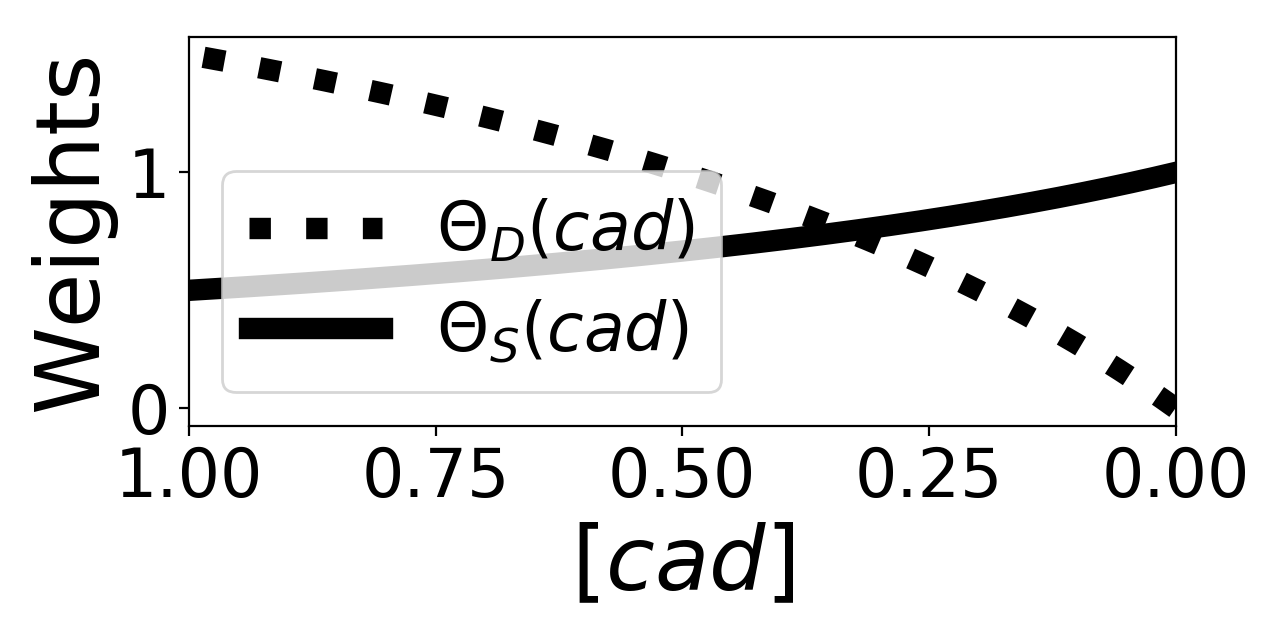

In [7]:
# Plot of the weights of the dynamic and static terms
plt.rcParams["figure.figsize"] = 6.4, 3.2
fig, ax = plt.subplots()

# Weights
g = np.arange(0., 1.001, 0.001)
ax.plot(g, 3.*g/(1.+g), c='k', ls=':', lw=7.7, label='$\Theta_D(cad)$')
ax.plot(g, 1./(1.+g), c='k', ls='-', lw=7.7, label='$\Theta_S(cad)$')

# Plot options
ax.set_xlim([1., 0.])
ax.set_xlabel('$[cad]$', fontsize=32)
ax.set_ylabel('Weights', fontsize=32)
ax.tick_params(labelsize=24)
ax.legend(fontsize=24, loc=3).set_zorder(20)

fig.tight_layout()
fig.show()

<IPython.core.display.Javascript object>


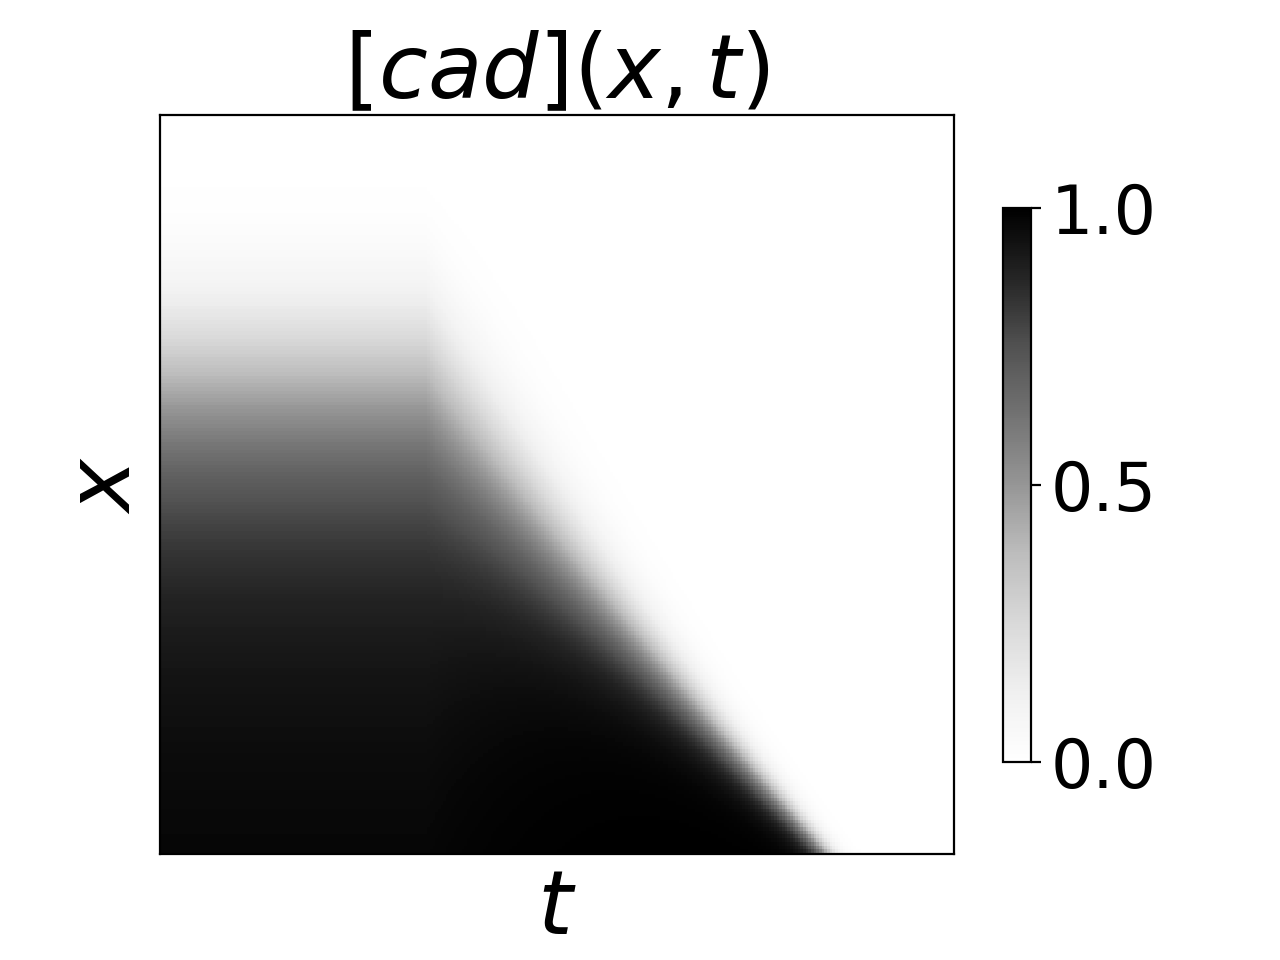

In [8]:
# Kymograph of the morphogen concentration
plt.rcParams["figure.figsize"] = 6.4, 4.8
fig, ax = plt.subplots()

# Kymograph
norm = colors.Normalize(vmin=0., vmax=1.)
kymo = ax.imshow(cad_gradient, norm=norm, cmap='Greys', aspect='auto')
  
# Colorbar
cb = fig.colorbar(kymo, ax=ax, shrink=0.75, ticks=[0., 0.5, 1.])
cb.ax.tick_params(labelsize=24)
   
# Other plot options
ax.set_title('$[cad](x,t)$', fontsize=32)
ax.set_xlabel('$t$', fontsize=32)
ax.set_ylabel('$x$', fontsize=32)
ax.set_ylim([param["n_cells"], 0])
ax.set_xticks([])
ax.set_yticks([])
    
fig.show()

####     

We now generate kymographs showing the dynamics of the 5 proteins in the simulated embryo.

<IPython.core.display.Javascript object>


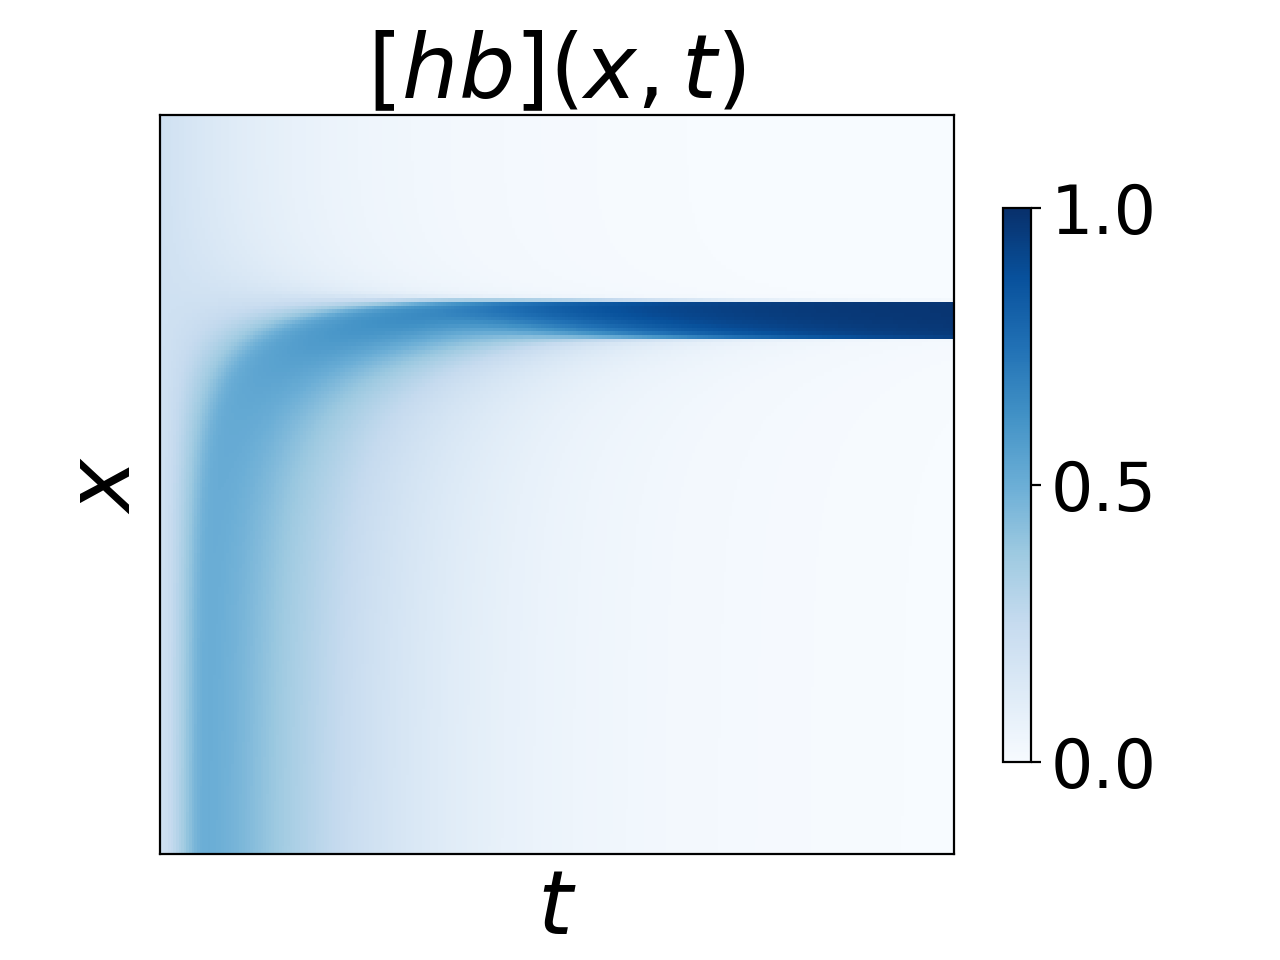

In [9]:
# Kymograph of the concentration of hunchback
plt.rcParams["figure.figsize"] = 6.4, 4.8
fig, ax = plt.subplots()
    
# Kymograph
norm = colors.Normalize(vmin=0., vmax=1.)
kymo = ax.imshow(results[:,0,:], norm=norm, cmap='Blues', aspect='auto')
    
# Colorbar
cb = fig.colorbar(kymo, ax=ax, shrink=0.75, ticks=[0., 0.5, 1.])
cb.ax.tick_params(labelsize=24)
  
# Other plot options
ax.set_title('$[hb](x,t)$', fontsize=32)
ax.set_xlabel('$t$', fontsize=32)
ax.set_ylabel('$x$', fontsize=32)
ax.set_ylim([param["n_cells"], 0])
ax.set_xticks([])
ax.set_yticks([])
    
fig.show()

<IPython.core.display.Javascript object>


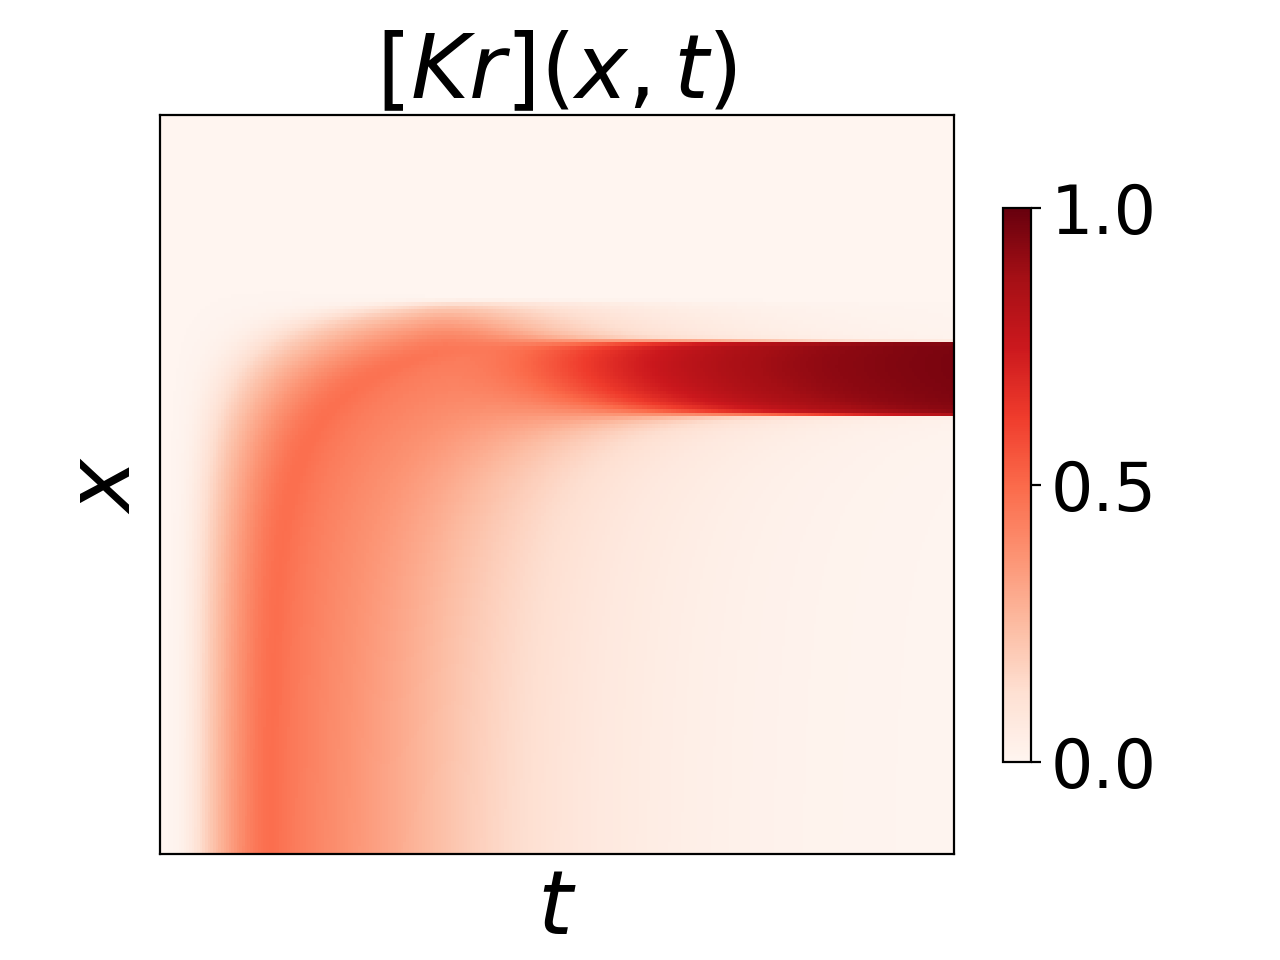

In [10]:
# Kymograph of the concentration of Krüppel
plt.rcParams["figure.figsize"] = 6.4, 4.8
fig, ax = plt.subplots()
  
# Kymograph
norm = colors.Normalize(vmin=0., vmax=1.)
kymo = ax.imshow(results[:,1,:], norm=norm, cmap='Reds', aspect='auto')
  
# Colorbar
cb = fig.colorbar(kymo, ax=ax, shrink=0.75, ticks=[0., 0.5, 1.])
cb.ax.tick_params(labelsize=24)
  
# Other plot options
ax.set_title('$[Kr](x,t)$', fontsize=32)
ax.set_xlabel('$t$', fontsize=32)
ax.set_ylabel('$x$', fontsize=32)
ax.set_ylim([param["n_cells"], 0])
ax.set_xticks([])
ax.set_yticks([])
    
fig.show()

<IPython.core.display.Javascript object>


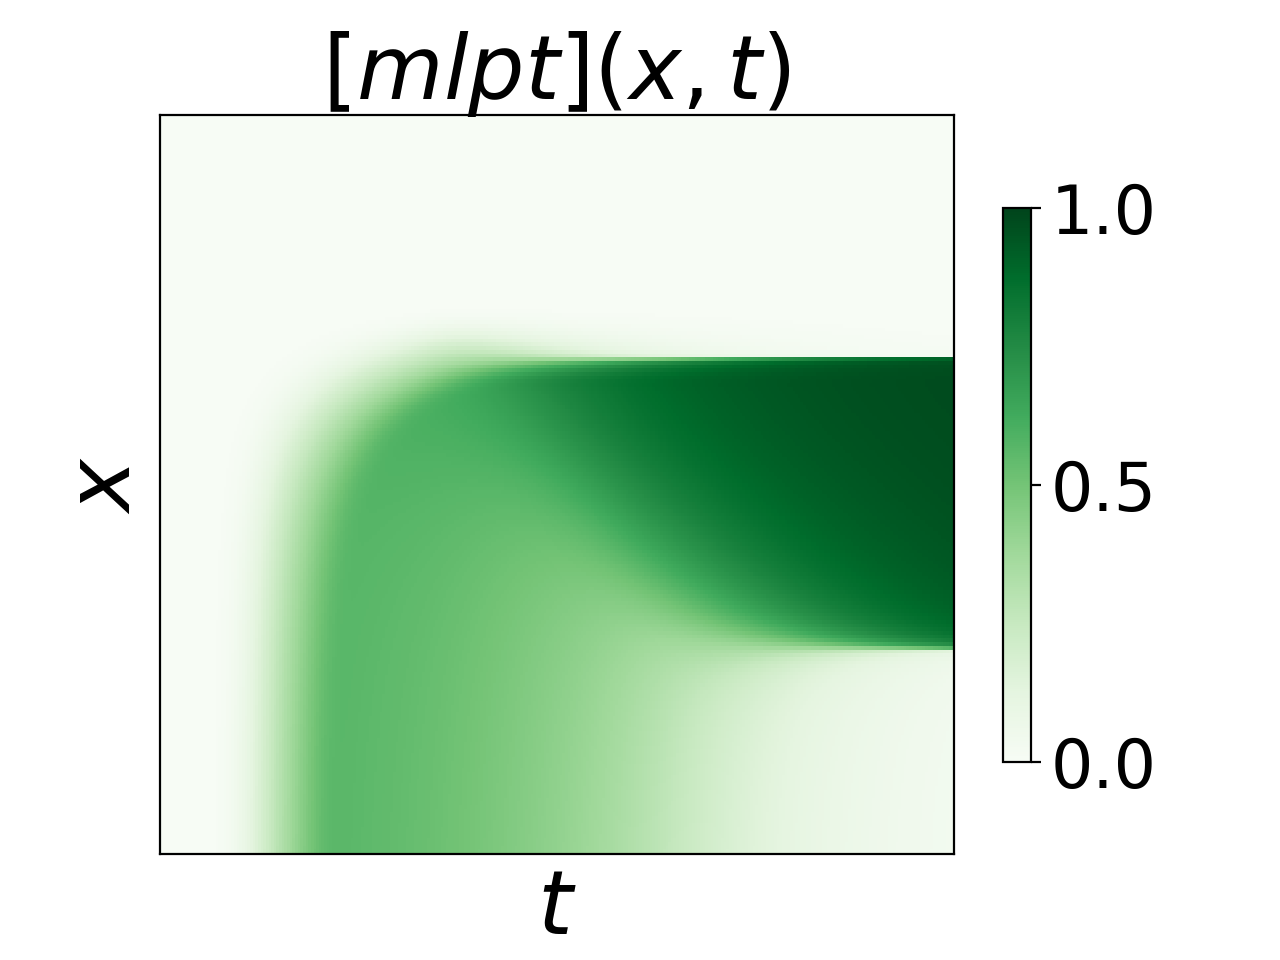

In [11]:
# Kymograph of the concentration of mille-pattes
plt.rcParams["figure.figsize"] = 6.4, 4.8
fig, ax = plt.subplots()
    
# Kymograph
norm = colors.Normalize(vmin=0., vmax=1.)
kymo = ax.imshow(results[:,2,:], norm=norm, cmap='Greens', aspect='auto')
  
# Colorbar
cb = fig.colorbar(kymo, ax=ax, shrink=0.75, ticks=[0., 0.5, 1.])
cb.ax.tick_params(labelsize=24)
  
# Other plot options
ax.set_title('$[mlpt](x,t)$', fontsize=32)
ax.set_xlabel('$t$', fontsize=32)
ax.set_ylabel('$x$', fontsize=32)
ax.set_ylim([param["n_cells"], 0])
ax.set_xticks([])
ax.set_yticks([])
    
fig.show()

<IPython.core.display.Javascript object>


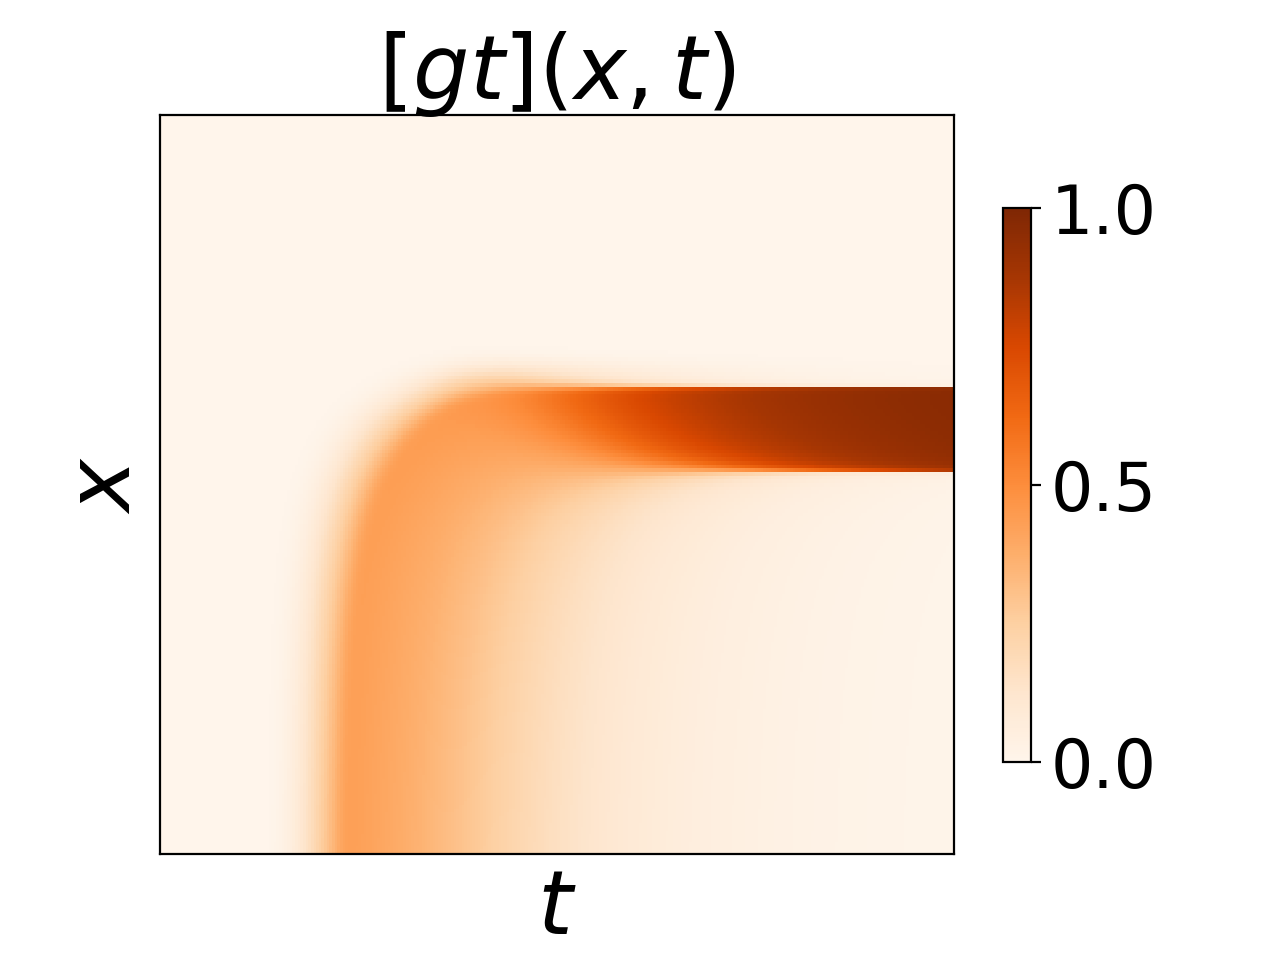

In [12]:
# Kymograph of the concentration of giant
plt.rcParams["figure.figsize"] = 6.4, 4.8
fig, ax = plt.subplots()
  
# Kymograph
norm = colors.Normalize(vmin=0., vmax=1.)
kymo = ax.imshow(results[:,3,:], norm=norm, cmap='Oranges', aspect='auto')
  
# Colorbar
cb = fig.colorbar(kymo, ax=ax, shrink=0.75, ticks=[0., 0.5, 1.])
cb.ax.tick_params(labelsize=24)
    
# Other plot options
ax.set_title('$[gt](x,t)$', fontsize=32)
ax.set_xlabel('$t$', fontsize=32)
ax.set_ylabel('$x$', fontsize=32)
ax.set_ylim([param["n_cells"], 0])
ax.set_xticks([])
ax.set_yticks([])
    
fig.show()

<IPython.core.display.Javascript object>


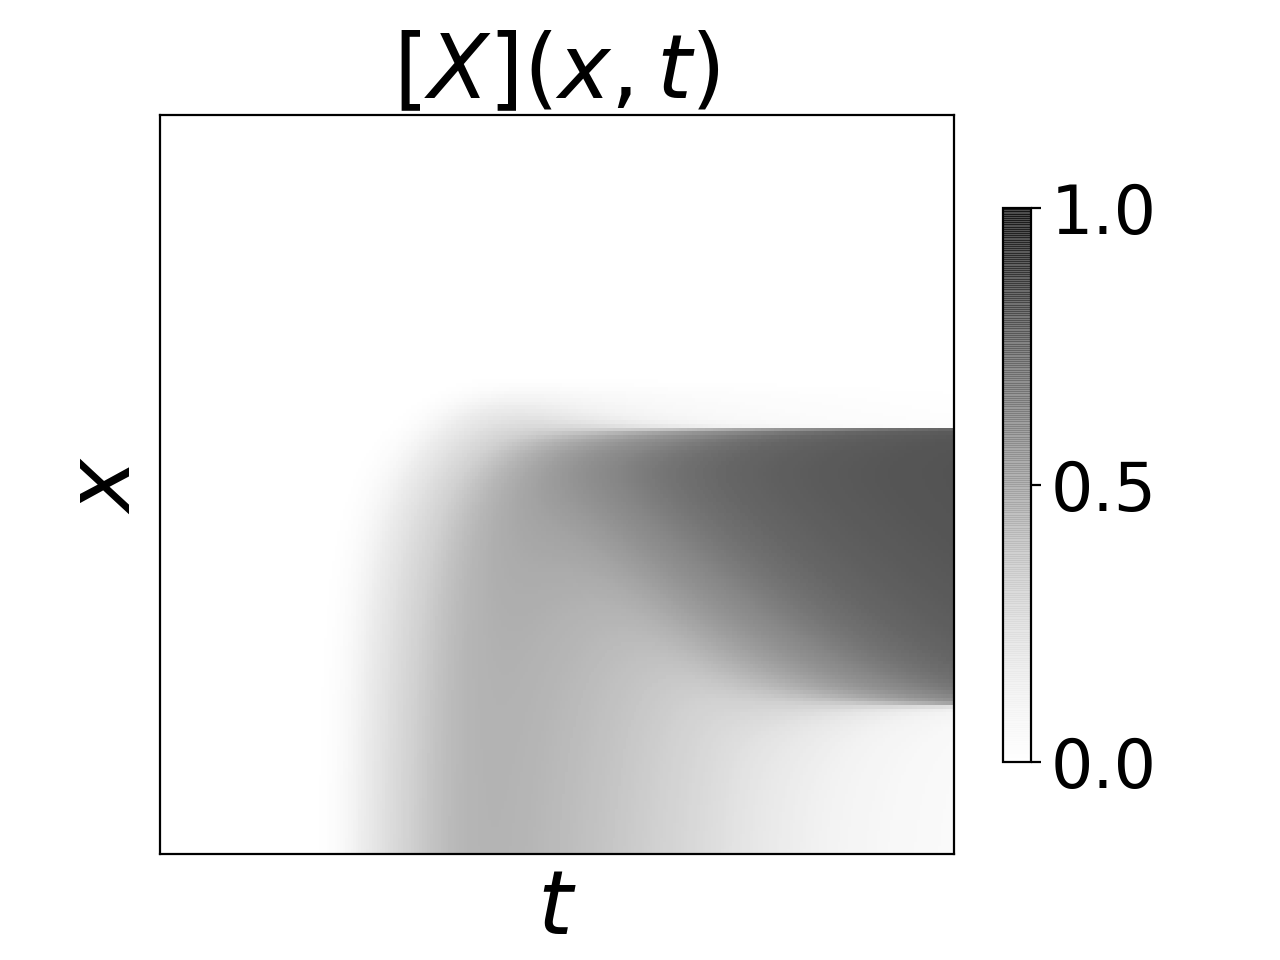

In [13]:
# Kymograph of the conecntration of X
plt.rcParams["figure.figsize"] = 6.4, 4.8
fig, ax = plt.subplots()
    
# Kymograph
norm = colors.Normalize(vmin=0., vmax=1.)
kymo = ax.imshow(results[:,4,:], norm=norm, cmap='Greys', alpha=0.7, aspect='auto')
  
# Colorbar
cb = fig.colorbar(kymo, ax=ax, shrink=0.75, ticks=[0., 0.5, 1.])
cb.ax.tick_params(labelsize=24)
 
# Other plot options
ax.set_title('$[X](x,t)$', fontsize=32)
ax.set_xlabel('$t$', fontsize=32)
ax.set_ylabel('$x$', fontsize=32)
ax.set_ylim([param["n_cells"], 0])
ax.set_xticks([])
ax.set_yticks([])
    
fig.show()

####     

**1.6 The final pattern of protein concentrations**

In this section, we plot the final pattern of protein concentrations across the simulated embryo. On this plot, we want to identify the proteins expressed in each region of the pattern. To achieve this, we use the following procedure:

1. We set a threshold of protein concentration.
2. For every cell, we create a vector of length 5 which encodes if the concetration of a given protein is above or below the thresold.
3. We place a boundary between two regions of the pattern at the position where this vector changes from a cell to the next.

In the next code cell, we repeat the procedure for different values of the threshold (between 0 and 1) and plot the positions of the boundaries identified for every value of the threshold.

<IPython.core.display.Javascript object>


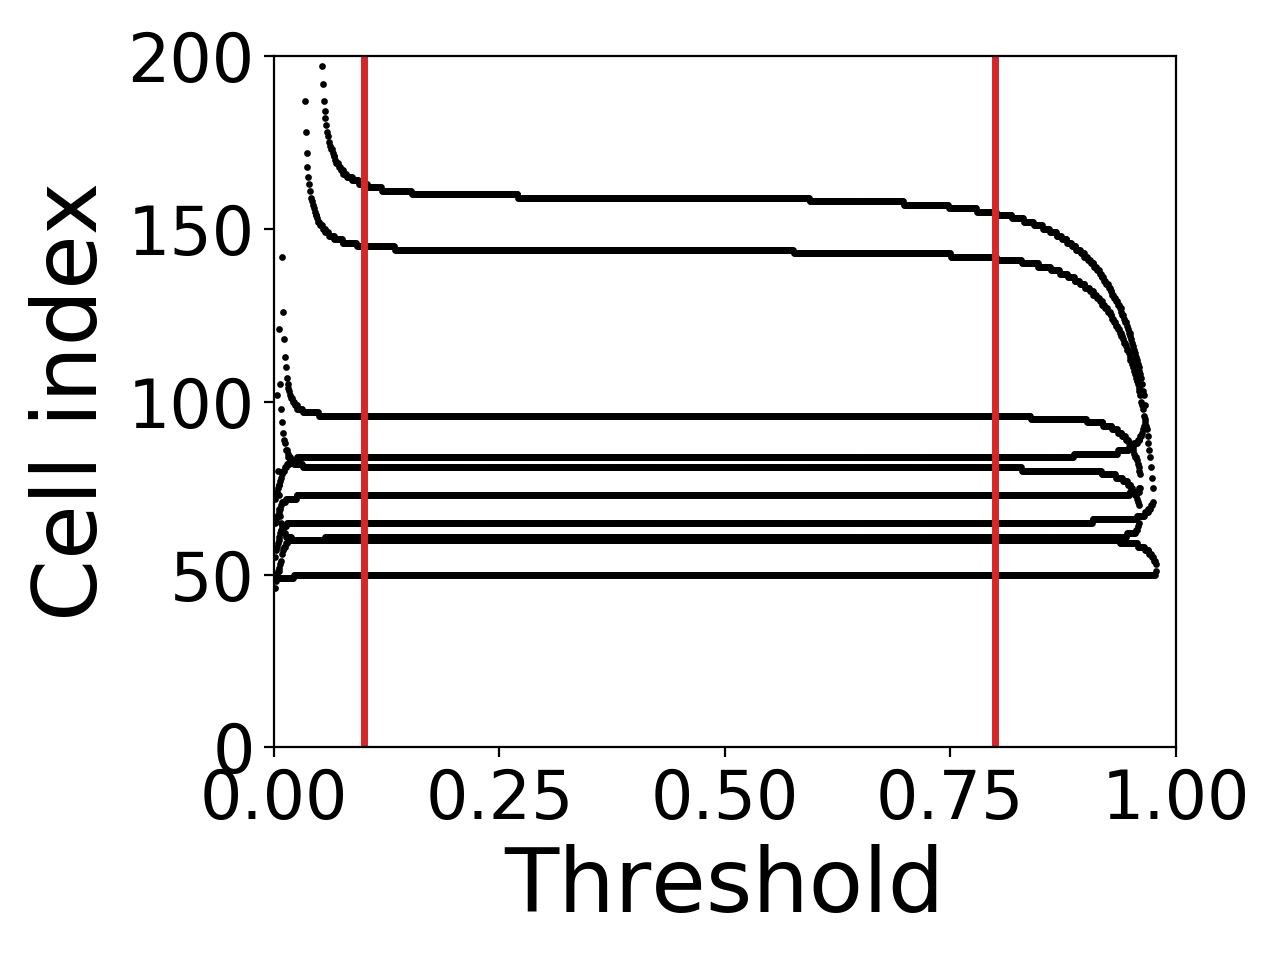

In [14]:
# Define an array with all the values considered for the threshold
threshold = np.arange(0., 1., 0.001)
pattern_boundaries = [[] for k in range(len(threshold))]
n_cells = param["n_cells"]

plt.rcParams["figure.figsize"] = 6.4, 4.8
fig, ax = plt.subplots()

# Compute the positions of the boundaries
for j in range(len(threshold)):
    
    pattern_matrix = np.zeros((n_cells, 5))
    pattern_matrix[results[:,:,-1] >= threshold[j]] = 1.

    for k in range(n_cells-1):
        if not(np.array_equal(pattern_matrix[k], pattern_matrix[k+1])):
            pattern_boundaries[j].append(k)
            
    # Plot the positions of the boundaries
    ax.scatter([threshold[j] for m in range(len(pattern_boundaries[j]))], pattern_boundaries[j], c='k', s=2)
    
    
# Plot vertical lines identifying intermediate values of the threshold
ax.plot([0.1, 0.1], [0, n_cells], 'tab:red', lw=2.5)
ax.plot([0.8, 0.8], [0, n_cells], 'tab:red', lw=2.5)

# Other plot options
ax.axis([0., 1., 0., n_cells])
ax.set_xlabel('Threshold', fontsize=32)
ax.set_ylabel('Cell index', fontsize=32)
ax.tick_params(labelsize=24)

fig.tight_layout()
fig.show()

####     

We see that the number of boundaries and the positions of the boundaries do not change substantially for intermediate values of the threshold (i.e. between the red lines). Now, we select one specific value of the threshold (say, 0.5) and make a plot to visualise the different regions of the pattern.

In [15]:
# Compute the positions of the pattern boundaries
threshold = 0.5
pattern_boundaries = []

pattern_matrix = np.zeros((param["n_cells"], 5))
pattern_matrix[results[:,:,-1] >= threshold] = 1.

for k in range(param["n_cells"]-1):
    if not(np.array_equal(pattern_matrix[k], pattern_matrix[k+1])):
        pattern_boundaries.append(k)

pattern_boundaries_norm = np.array(pattern_boundaries)/param["n_cells"]

<IPython.core.display.Javascript object>


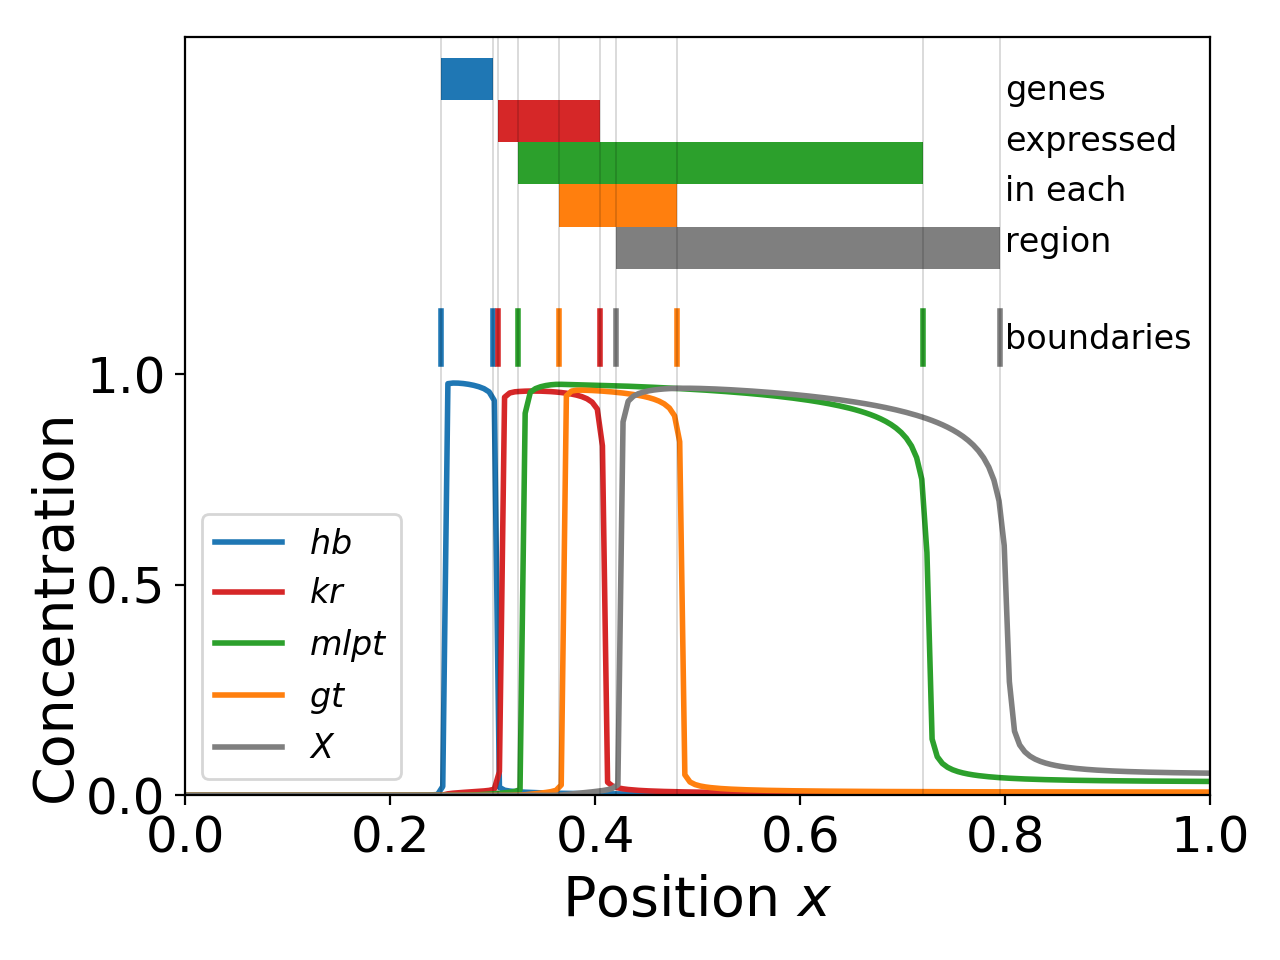

In [16]:
# Plot the final pattern of protein concentrations
plt.rcParams["figure.figsize"] = 6.4, 4.8
fig, ax = plt.subplots()
  
# Final pattern
ap_positions = np.linspace(0.0, 1.0, param["n_cells"])
proteins_colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:orange', 'tab:grey']
proteins_names = ['$hb$', '$kr$', '$mlpt$', '$gt$', '$X$']
for j in range(5):
    ax.plot(ap_positions, results[:,j,-1], proteins_colors[j], label=proteins_names[j], lw=2)

# Boundaries
boundary_colors = ['tab:blue', 'tab:blue', 'tab:red', 'tab:green', 'tab:orange', 'tab:red', 'tab:grey', 'tab:orange', 'tab:green', 'tab:grey']
for k in range(len(pattern_boundaries)):
    ax.plot([pattern_boundaries_norm[k], pattern_boundaries_norm[k]], [1.025, 1.15], boundary_colors[k], lw=2)
    ax.plot([pattern_boundaries_norm[k], pattern_boundaries_norm[k]], [0., 2.], 'k', lw=0.1)

# Regions
ax.fill_between([pattern_boundaries_norm[6], pattern_boundaries_norm[9]], [1.25, 1.25], [1.35, 1.35], facecolor='tab:grey')
ax.fill_between([pattern_boundaries_norm[4], pattern_boundaries_norm[7]], [1.35, 1.35], [1.45, 1.45], facecolor='tab:orange')
ax.fill_between([pattern_boundaries_norm[3], pattern_boundaries_norm[8]], [1.45, 1.45], [1.55, 1.55], facecolor='tab:green')
ax.fill_between([pattern_boundaries_norm[2], pattern_boundaries_norm[5]], [1.55, 1.55], [1.65, 1.65], facecolor='tab:red')
ax.fill_between([pattern_boundaries_norm[0], pattern_boundaries_norm[1]], [1.65, 1.65], [1.75, 1.75], facecolor='tab:blue')

# Text
ax.text(0.8, 1.65, 'genes', fontsize=12)
ax.text(0.8, 1.53, 'expressed', fontsize=12)
ax.text(0.8, 1.41, 'in each', fontsize=12)
ax.text(0.8, 1.29, 'region', fontsize=12)
ax.text(0.8, 1.06, 'boundaries', fontsize=12)

# Other plot options
ax.axis([0., 1., 0., 1.8])
ax.set_xlabel('Position $x$', fontsize=20)
ax.set_ylabel('Concentration', fontsize=20)
ax.yaxis.set_label_coords(-0.1,0.25)
ax.set_yticks([0., 0.5, 1.])
ax.tick_params(labelsize=18)
ax.legend(loc=3, fontsize=12)

fig.tight_layout()
fig.show()

####    

In the next code cell, we generate a simplified version of this plot. We also indentify the position of two cells for which we will plot the trajectory in phase space in the next section of this notebook. 

<IPython.core.display.Javascript object>


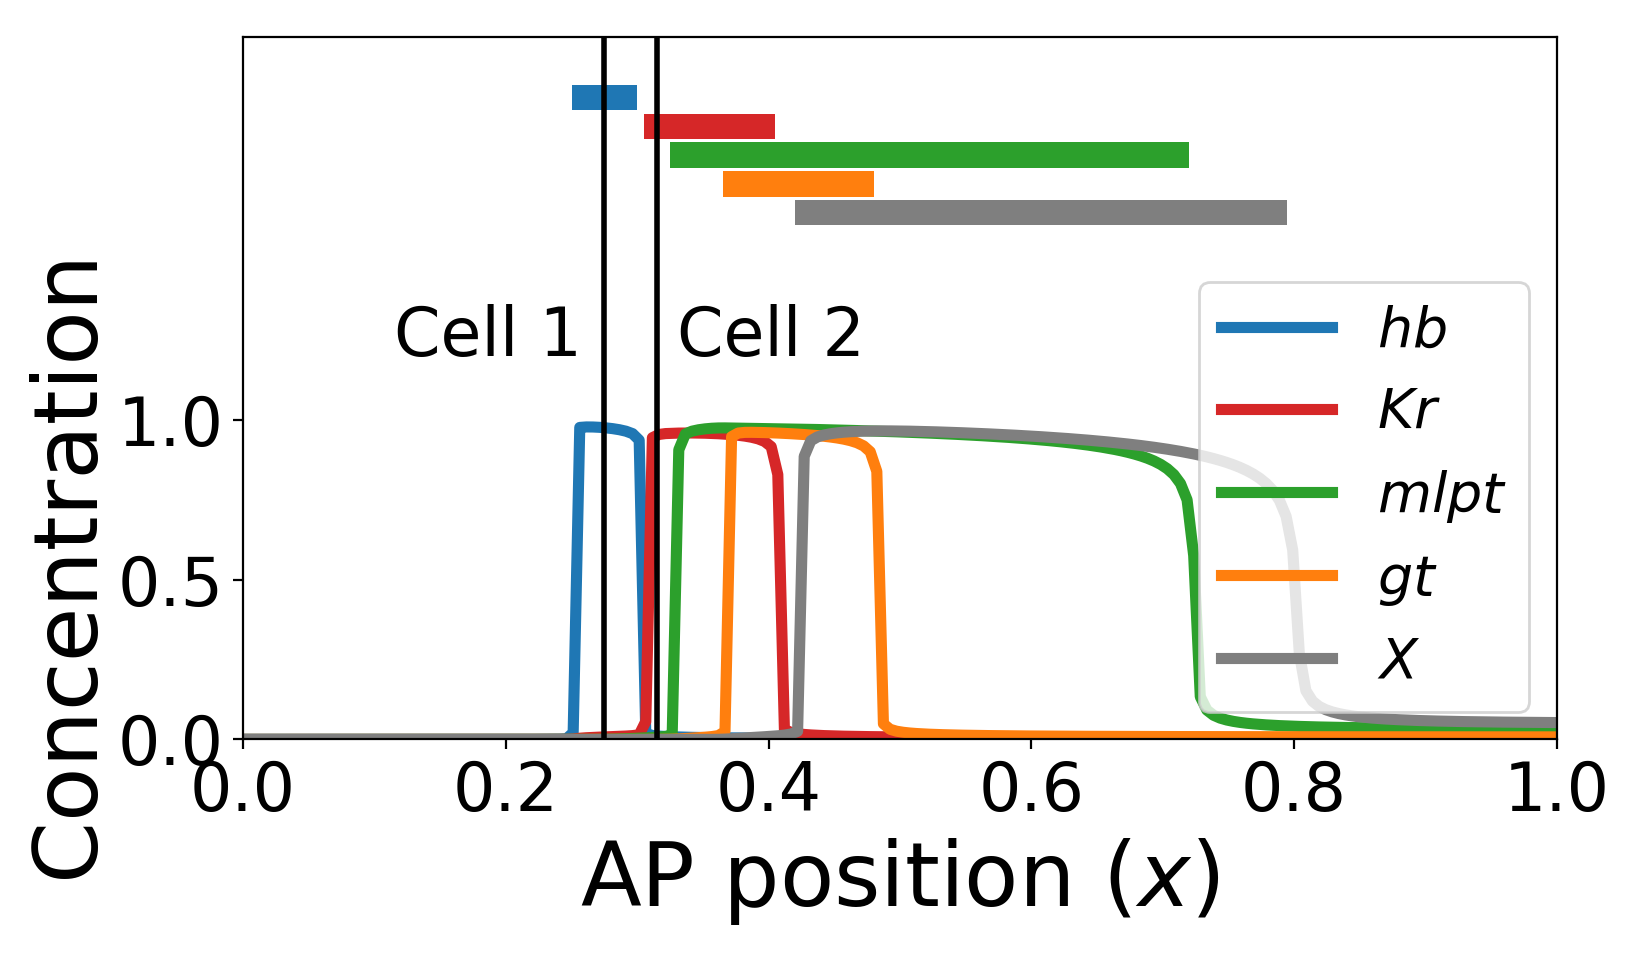

In [17]:
plt.rcParams["figure.figsize"] = 8.2, 4.8
fig, ax = plt.subplots()

# Final pattern of protein concentrations    
ap_positions = np.linspace(0.0, 1.0, param["n_cells"])
proteins_colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:orange', 'tab:grey']
proteins_names = ['$hb$', '$Kr$', '$mlpt$', '$gt$', '$X$']
for j in range(5):
    ax.plot(ap_positions, results[:,j,-1], proteins_colors[j], label=proteins_names[j], lw=4)

# Pattern schematic
line_start = 1.6
line_thickness = 0.08
line_spacing = 0.01
index_pattern_boundaries = np.array([[6,9], [4,7], [3,8], [2,5], [0,1]])

for k in range(5):
    ax.fill_between([pattern_boundaries_norm[index_pattern_boundaries[k,0]],
                    pattern_boundaries_norm[index_pattern_boundaries[k,1]]],
                    [line_start+(k+1)*line_spacing+k*line_thickness, line_start+(k+1)*line_spacing+k*line_thickness],
                    [line_start+(k+1)*line_spacing+(k+1)*line_thickness, line_start+(k+1)*line_spacing+(k+1)*line_thickness],
                    facecolor=proteins_colors[4-k])

# Identify cells
cell_indices = np.array([55, 63])
cell_positions = cell_indices/param["n_cells"]
ax.plot([cell_positions[0], cell_positions[0]], [0.,2.2], c='k', lw=2)
ax.text(0.115, 1.2, 'Cell 1', fontsize=24) 
ax.plot([cell_positions[1], cell_positions[1]], [0.,2.2], c='k', lw=2) 
ax.text(0.33, 1.2, 'Cell 2', fontsize=24)

# Other plot options
ax.axis([0., 1., 0., 2.2])
ax.set_xlabel('AP position ($x$)', fontsize=32)
ax.set_ylabel('Concentration', fontsize=32)
ax.yaxis.set_label_coords(-0.1,0.25)
ax.legend(loc=4, fontsize=20)
ax.set_yticks([0., 0.5, 1.])
ax.tick_params(labelsize=24)

fig.tight_layout()
fig.show()

####     

**2. Flow plots**

In the following code cells, we plot the flow of the Tribolium model on a 2D plane with axes corresponding to the concentrations of the first two proteins expressed in the cascade, $hb$ and $Kr$. We fix the concentrations of all other proteins in the cascade to 0, but consider different concentrations of morphogen $cad$ and make a flow plot for each of these concentrations. The goal is to visualise the formation of the fixed point corresponding to the first region of the pattern, where only $hb$ is expressed.


####     

**2.1 Redefining the ODEs**

To get the flow, we will use the `matplotlib` function `streamplot`. This function requires that we define the ODEs for $hb$ and $Kr$ in separate functions. We also make an array of values of $cad$ for which we want to plot the flow and place the position of the fixed point at each of these 3 values of $cad$ in an array. The position of the fixed point with was determined the `XPP AUTO` software. Finally, we generate a grid of points in ($hb$, $Kr$) space at which the flow will be computed.

In [18]:
def d_hb(hb, kr, mlpt, gt, x , cad):
    
    c = 1./(1.+cad)
    ddyn = 3.*cad*c *(hb/0.2)**5/(1.0 +(hb/0.2)**5) /(1.0 +(kr/0.12)**5)
    dstat = c *(hb/0.4)**5/(1.0 +(hb/0.4)**5) /(1.0 +(kr/0.4)**5)
    
    return ddyn +dstat -hb


def d_kr(hb, kr, mlpt, gt, x , cad):
    
    c = 1./(1.+cad)
    ddyn = 3.*cad*c *(hb/0.4)**5/(1.0 +(hb/0.4)**5) /(1.0 +(mlpt/0.25)**5) /(1.0 +(gt/0.01)**5)
    dstat = c *(kr/0.4)**5/(1.0 +(kr/0.4)**5) /(1.0 +(hb/0.4)**5)
    
    return ddyn +dstat -kr



cad_values = [0.155, 0.13, 0.]
fixed_pt_position = np.array([[-10.,-10.], [0.548,0.323], [1.,0.]])

var_max = 1.
var_min = 0.0
var_step = 0.005
hb_array = np.arange(var_min, var_max+var_step, var_step)
kr_array = np.arange(var_min, var_max+var_step, var_step)
hb_grid, kr_grid = np.meshgrid(hb_array, kr_array)

####     

**2.2 Generating the flow plots**

On each flow plot, we represent the flow with thin black arrows. We also show the position of the fixed point with a green disk. For each value of $cad$, we make two flow plots. On the first plot, we project the complete trajectories of all cells. A trajectory is shown in blue (red and black, respectively) if that cells ends up with a high concentration of $hb$ ($Kr$ and $X$, respectively) at the end of the simulation. This allows us to assign a single color to each cell since the domains of the final pattern in which the 3 proteins $hb$, $Kr$ and $X$ are expressed are non-overlapping. On the second flow plot, we project the trajectory of two representatitive cells: "cell 1" ends up in the first region of the pattern, while "cell 2" does not. On this plot, we project only the part of the trajectory from the beginning of the simulation until the concentration of $cad$ in that cell reaches the value used to generate the plot.


####     

**2.2.1 The flow right before the formation of the fixed point**

In the following code cells, we generate the two flow plots for $cad = 0.155$.

In [19]:
# Compute the flow
hb_flow = d_hb(hb_grid, kr_grid, 0., 0., 0., cad_values[0])
kr_flow = d_kr(hb_grid, kr_grid, 0., 0., 0., cad_values[0])

# Find the position of Cell 1
for j in range(len(times)):
    if (cad_gradient[cell_indices[0],j] <= cad_values[0]):
        cell1_t_index = j
        break
        
# Find the position of Cell 2
for j in range(len(times)):
    if (cad_gradient[cell_indices[1],j] <= cad_values[0]):
        cell2_t_index = j
        break

<IPython.core.display.Javascript object>


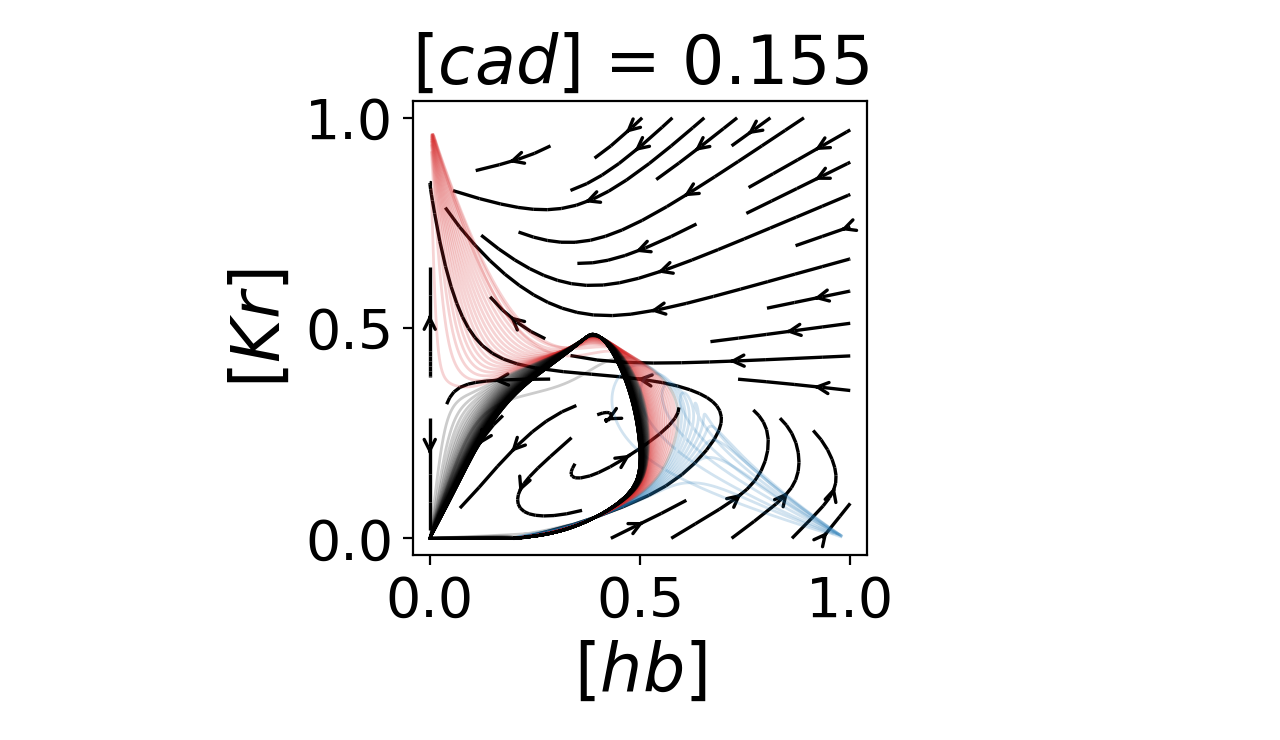

In [20]:
# First flow plot
plt.rcParams["figure.figsize"] = 6.4, 3.7
fig, ax = plt.subplots()

# Flow
ax.streamplot(hb_grid, kr_grid, hb_flow, kr_flow, color='k', density=0.5, linewidth=1.2, arrowstyle='->', zorder=0)

# Fixed point
ax.scatter(fixed_pt_position[0,0], fixed_pt_position[0,1], c='tab:green', s=400, zorder=1)

# Trajectories
for k in range(param["n_cells"]):
    
    if ((k > pattern_boundaries[index_pattern_boundaries[-1,0]])
    and (k <= pattern_boundaries[index_pattern_boundaries[-1,1]])):
        ax.plot(results[k,0], results[k,1], c='tab:blue', alpha=0.2, lw=1, zorder=2)
    
    elif ((k > pattern_boundaries[index_pattern_boundaries[-2,0]])
    and (k <= pattern_boundaries[index_pattern_boundaries[-2,1]])):
        ax.plot(results[k,0], results[k,1], c='tab:red', alpha=0.2, lw=1, zorder=2)
    
    else:
        ax.plot(results[k,0], results[k,1], c='k', alpha=0.2, lw=1, zorder=2)
    
# Other plot options  
ax.set_title('$[cad]$ = '+str(cad_values[0]), fontsize=24)
ax.set_aspect('equal')
ax.set_xlabel('$[hb]$', fontsize=24)
ax.set_ylabel('$[Kr]$', fontsize=24)
ax.set_xlim(-0.04, 1.04)
ax.set_ylim(-0.04, 1.04)
ax.tick_params(labelsize=20)
ax.set_xticks([0., 0.5, 1.])
ax.set_yticks([0., 0.5, 1.])

fig.tight_layout()
fig.show()

<IPython.core.display.Javascript object>


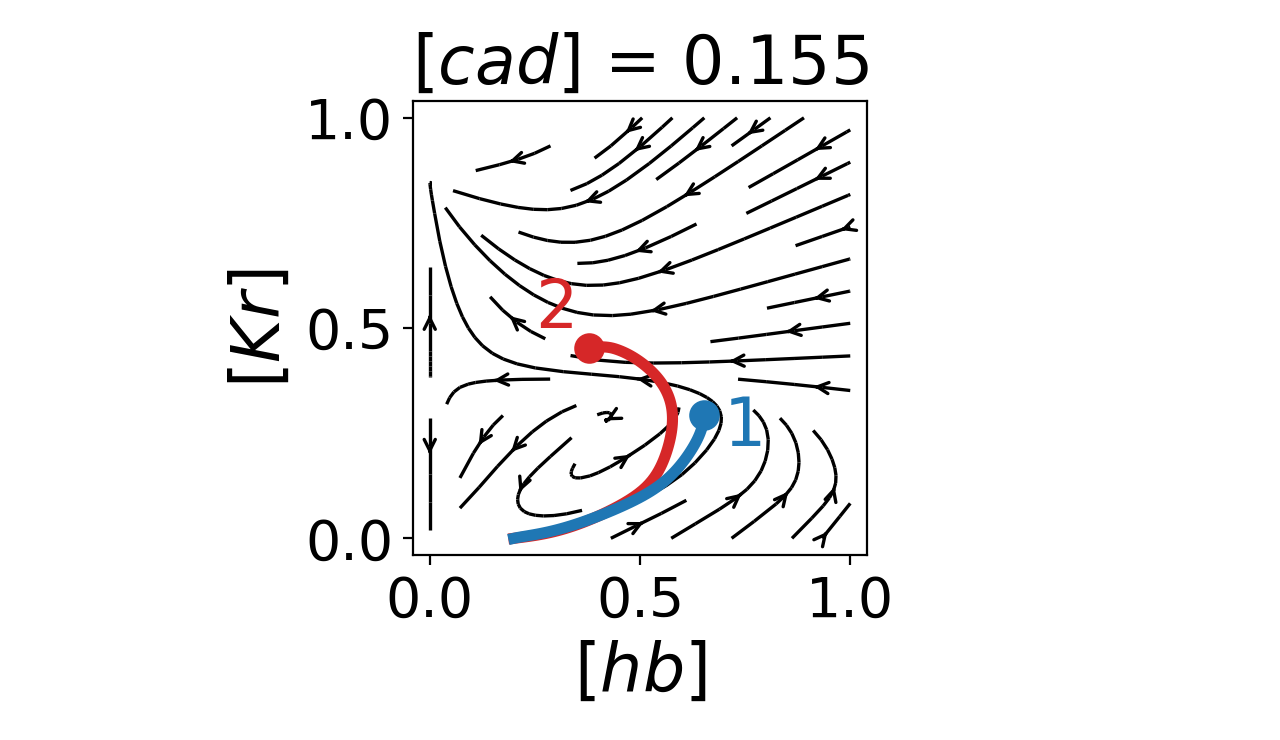

In [21]:
# Second flow plot
plt.rcParams["figure.figsize"] = 6.4, 3.7
fig, ax = plt.subplots()

# Flow
ax.streamplot(hb_grid, kr_grid, hb_flow, kr_flow, color='k', density=0.5, linewidth=1.2, arrowstyle='->', zorder=0)

# Fixed point
ax.scatter(fixed_pt_position[0,0], fixed_pt_position[0,1], c='tab:green', s=400, zorder=1)
    
# Trajectory of Cell 1
ax.plot(results[cell_indices[0],0,:cell1_t_index], results[cell_indices[0],1,:cell1_t_index], c='tab:blue', lw=4, zorder=10)
ax.scatter(results[cell_indices[0],0,cell1_t_index], results[cell_indices[0],1,cell1_t_index], c='tab:blue', s=100, zorder=11)
ax.text(0.7, 0.22, '1', color='tab:blue', fontsize=24)

# Trajectory of Cell 2
ax.plot(results[cell_indices[1],0,:cell2_t_index], results[cell_indices[1],1,:cell2_t_index], c='tab:red', lw=4, zorder=7)
ax.scatter(results[cell_indices[1],0,cell2_t_index], results[cell_indices[1],1,cell2_t_index], c='tab:red', s=100, zorder=8)
ax.text(0.25, 0.5, '2', color='tab:red', fontsize=24)

# Other plot options 
ax.set_title('$[cad]$ = '+str(cad_values[0]), fontsize=24)
ax.set_aspect('equal')
ax.set_xlabel('$[hb]$', fontsize=24)
ax.set_ylabel('$[Kr]$', fontsize=24)
ax.set_xlim(-0.04, 1.04)
ax.set_ylim(-0.04, 1.04)
ax.tick_params(labelsize=20)
ax.set_xticks([0., 0.5, 1.])
ax.set_yticks([0., 0.5, 1.])

fig.tight_layout()
fig.show()

####     

**2.2.2 The flow right after the formation of the fixed point**

In the following code cells, we generate the two flow plots for $cad = 0.13$.

In [22]:
# Compute the flow
hb_flow = d_hb(hb_grid, kr_grid, 0., 0., 0., cad_values[1])
kr_flow = d_kr(hb_grid, kr_grid, 0., 0., 0., cad_values[1])

# Find the position of Cell 1
for j in range(len(times)):
    if (cad_gradient[cell_indices[0],j] <= cad_values[1]):
        cell1_t_index = j
        break
        
# Find the position of Cell 2
for j in range(len(times)):
    if (cad_gradient[cell_indices[1],j] <= cad_values[1]):
        cell2_t_index = j
        break

<IPython.core.display.Javascript object>


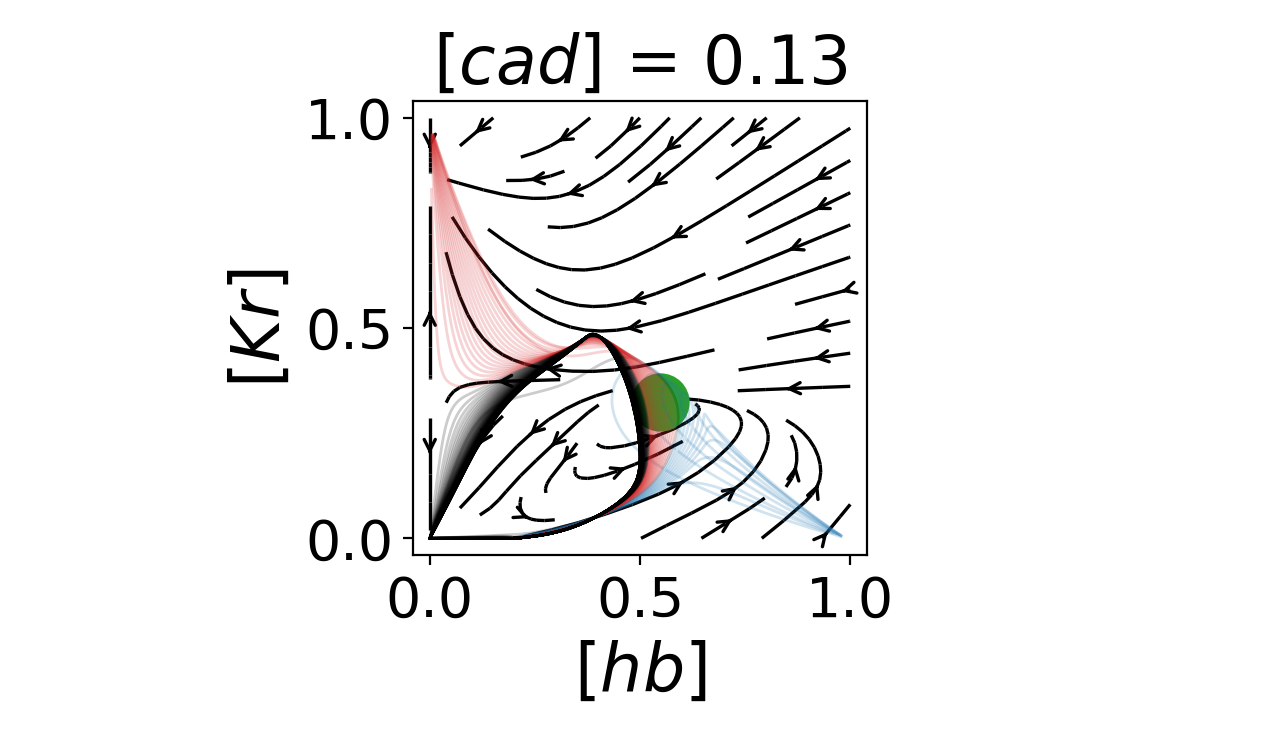

In [23]:
# First flow plot
plt.rcParams["figure.figsize"] = 6.4, 3.7
fig, ax = plt.subplots()

# Flow
ax.streamplot(hb_grid, kr_grid, hb_flow, kr_flow, color='k', density=0.5, linewidth=1.2, arrowstyle='->', zorder=0)

# Fixed point
ax.scatter(fixed_pt_position[1,0], fixed_pt_position[1,1], c='tab:green', s=400, zorder=1)

# Trajectories
for k in range(param["n_cells"]):
    
    if ((k > pattern_boundaries[index_pattern_boundaries[-1,0]])
    and (k <= pattern_boundaries[index_pattern_boundaries[-1,1]])):
        ax.plot(results[k,0], results[k,1], c='tab:blue', alpha=0.2, lw=1, zorder=2)
    
    elif ((k > pattern_boundaries[index_pattern_boundaries[-2,0]])
    and (k <= pattern_boundaries[index_pattern_boundaries[-2,1]])):
        ax.plot(results[k,0], results[k,1], c='tab:red', alpha=0.2, lw=1, zorder=2)
    
    else:
        ax.plot(results[k,0], results[k,1], c='k', alpha=0.2, lw=1, zorder=2)
    
# Other plot options  
ax.set_title('$[cad]$ = '+str(cad_values[1]), fontsize=24)
ax.set_aspect('equal')
ax.set_xlabel('$[hb]$', fontsize=24)
ax.set_ylabel('$[Kr]$', fontsize=24)
ax.set_xlim(-0.04, 1.04)
ax.set_ylim(-0.04, 1.04)
ax.tick_params(labelsize=20)
ax.set_xticks([0., 0.5, 1.])
ax.set_yticks([0., 0.5, 1.])

fig.tight_layout()
fig.show()

<IPython.core.display.Javascript object>


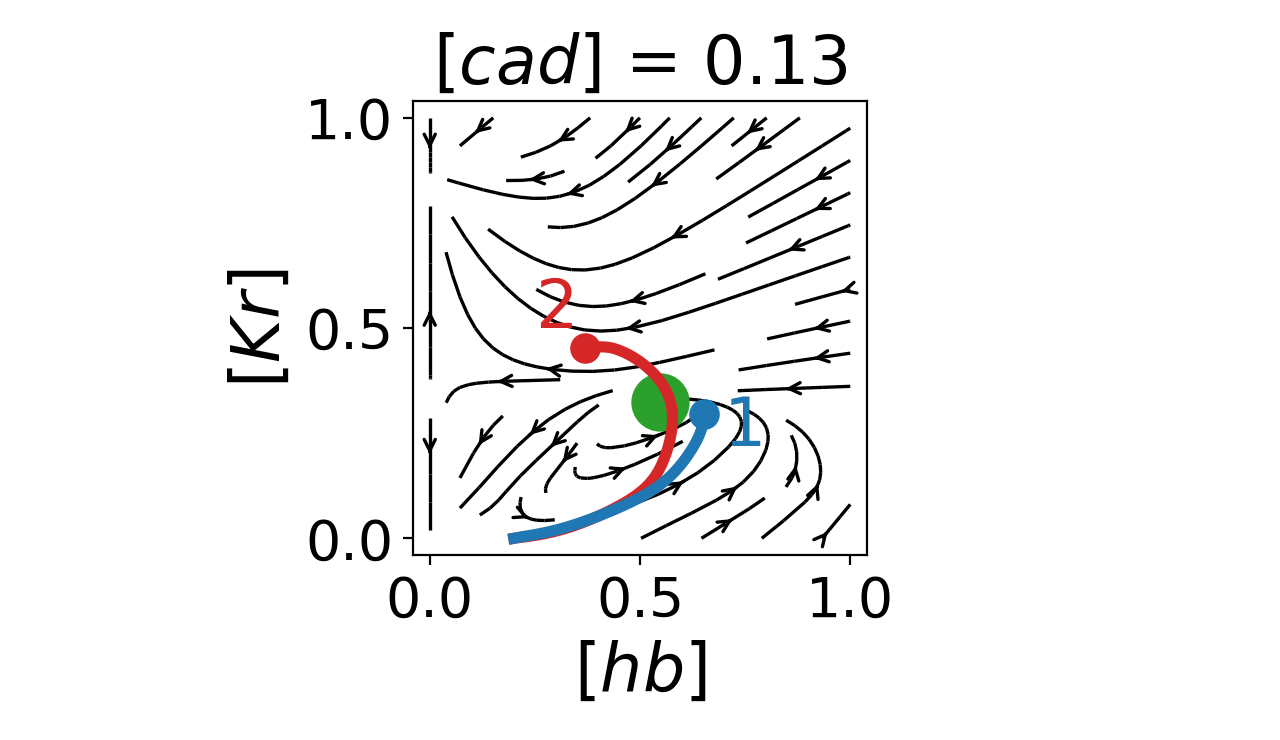

In [24]:
# Second flow plot
plt.rcParams["figure.figsize"] = 6.4, 3.7
fig, ax = plt.subplots()

# Flow
ax.streamplot(hb_grid, kr_grid, hb_flow, kr_flow, color='k', density=0.5, linewidth=1.2, arrowstyle='->', zorder=0)

# Fixed point
ax.scatter(fixed_pt_position[1,0], fixed_pt_position[1,1], c='tab:green', s=400, zorder=1)
    
# Trajectory of Cell 1
ax.plot(results[cell_indices[0],0,:cell1_t_index], results[cell_indices[0],1,:cell1_t_index], c='tab:blue', lw=4, zorder=10)
ax.scatter(results[cell_indices[0],0,cell1_t_index], results[cell_indices[0],1,cell1_t_index], c='tab:blue', s=100, zorder=11)
ax.text(0.7, 0.22, '1', color='tab:blue', fontsize=24)

# Trajectory of Cell 2
ax.plot(results[cell_indices[1],0,:cell2_t_index], results[cell_indices[1],1,:cell2_t_index], c='tab:red', lw=4, zorder=7)
ax.scatter(results[cell_indices[1],0,cell2_t_index], results[cell_indices[1],1,cell2_t_index], c='tab:red', s=100, zorder=8)
ax.text(0.25, 0.5, '2', color='tab:red', fontsize=24)

# Other plot options 
ax.set_title('$[cad]$ = '+str(cad_values[1]), fontsize=24)
ax.set_aspect('equal')
ax.set_xlabel('$[hb]$', fontsize=24)
ax.set_ylabel('$[Kr]$', fontsize=24)
ax.set_xlim(-0.04, 1.04)
ax.set_ylim(-0.04, 1.04)
ax.tick_params(labelsize=20)
ax.set_xticks([0., 0.5, 1.])
ax.set_yticks([0., 0.5, 1.])

fig.tight_layout()
fig.show()

####     

**2.2.3 The flow at the end of the simulation**

In the following code cells, we generate the two flow plots for $cad = 0$. 

In [25]:
# Compute the flow
hb_flow = d_hb(hb_grid, kr_grid, 0., 0., 0., cad_values[2])
kr_flow = d_kr(hb_grid, kr_grid, 0., 0., 0., cad_values[2])

<IPython.core.display.Javascript object>


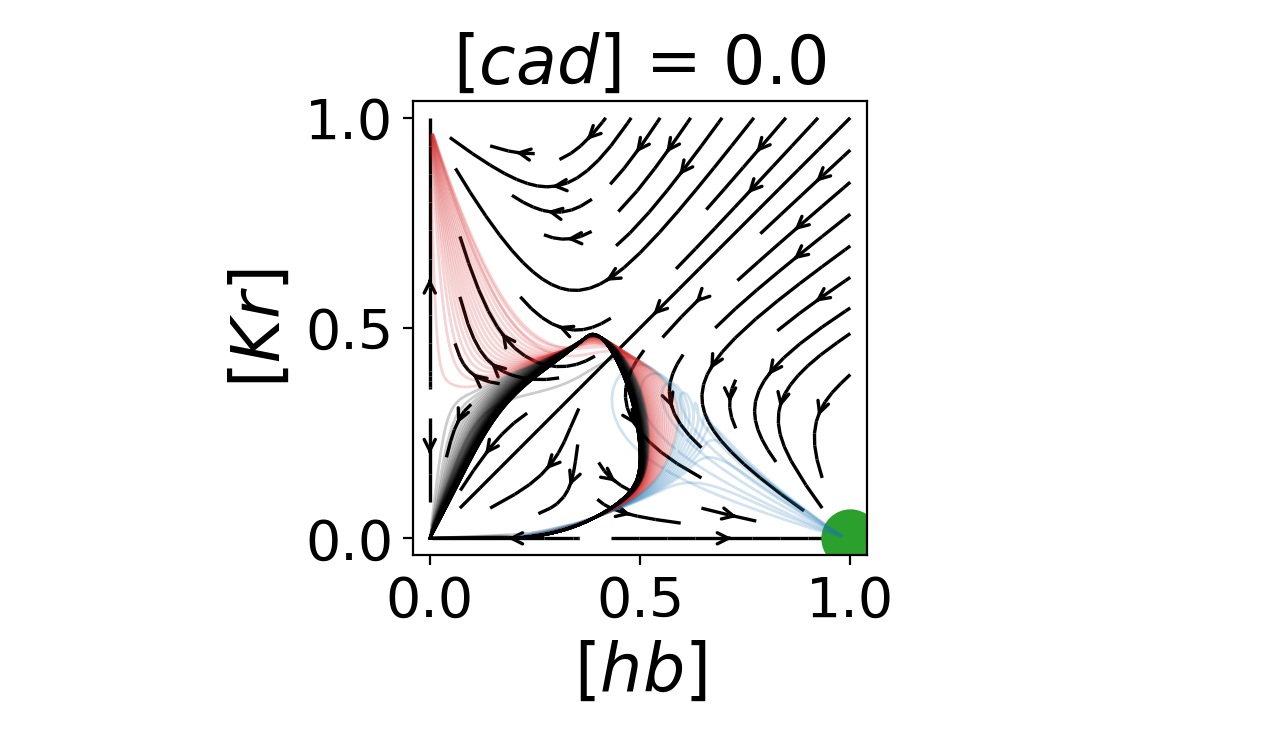

In [26]:
# First flow plot
plt.rcParams["figure.figsize"] = 6.4, 3.7
fig, ax = plt.subplots()

# Flow
ax.streamplot(hb_grid, kr_grid, hb_flow, kr_flow, color='k', density=0.5, linewidth=1.2, arrowstyle='->', zorder=0)

# Fixed point
ax.scatter(fixed_pt_position[2,0], fixed_pt_position[2,1], c='tab:green', s=400, zorder=1)

# Trajectories
for k in range(param["n_cells"]):
    
    if ((k > pattern_boundaries[index_pattern_boundaries[-1,0]])
    and (k <= pattern_boundaries[index_pattern_boundaries[-1,1]])):
        ax.plot(results[k,0], results[k,1], c='tab:blue', alpha=0.2, lw=1, zorder=2)
    
    elif ((k > pattern_boundaries[index_pattern_boundaries[-2,0]])
    and (k <= pattern_boundaries[index_pattern_boundaries[-2,1]])):
        ax.plot(results[k,0], results[k,1], c='tab:red', alpha=0.2, lw=1, zorder=2)
    
    else:
        ax.plot(results[k,0], results[k,1], c='k', alpha=0.2, lw=1, zorder=2)
    
# Other plot options  
ax.set_title('$[cad]$ = '+str(cad_values[2]), fontsize=24)
ax.set_aspect('equal')
ax.set_xlabel('$[hb]$', fontsize=24)
ax.set_ylabel('$[Kr]$', fontsize=24)
ax.set_xlim(-0.04, 1.04)
ax.set_ylim(-0.04, 1.04)
ax.tick_params(labelsize=20)
ax.set_xticks([0., 0.5, 1.])
ax.set_yticks([0., 0.5, 1.])

fig.tight_layout()
fig.show()

<IPython.core.display.Javascript object>


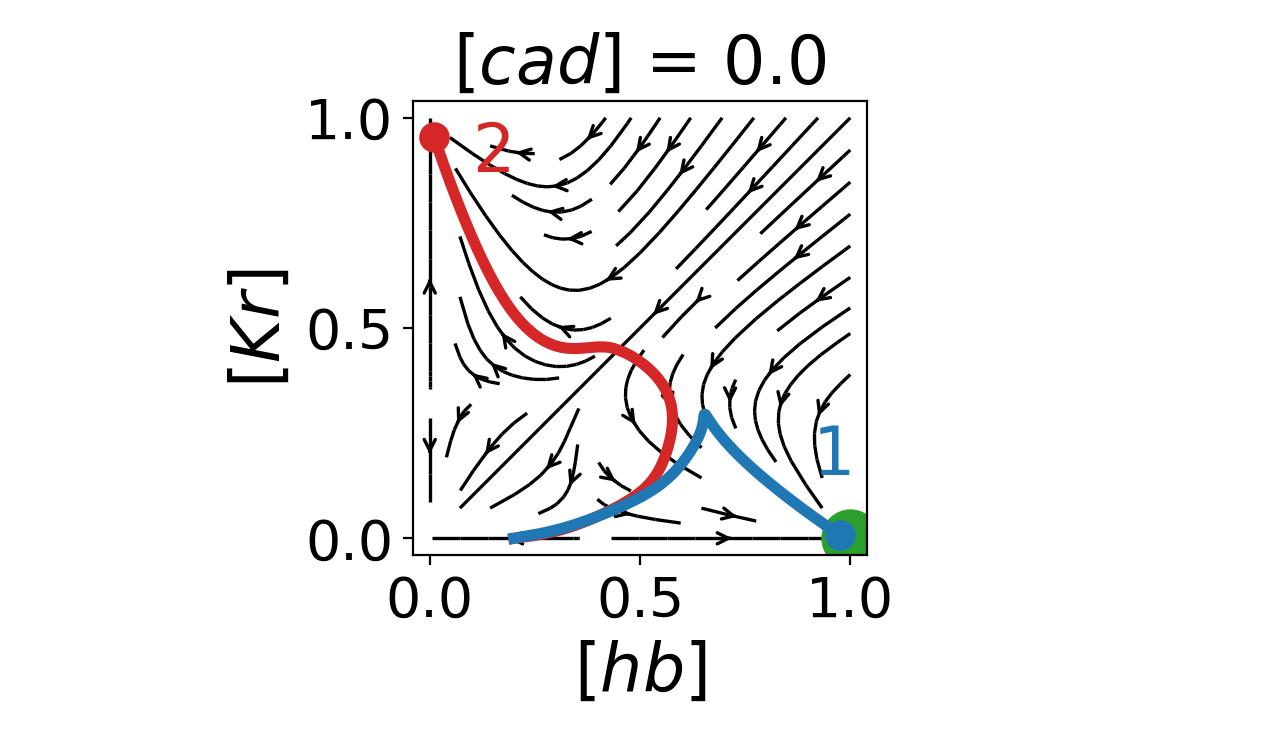

In [27]:
# Second flow plot
plt.rcParams["figure.figsize"] = 6.4, 3.7
fig, ax = plt.subplots()

# Flow
ax.streamplot(hb_grid, kr_grid, hb_flow, kr_flow, color='k', density=0.5, linewidth=1.2, arrowstyle='->', zorder=0)

# Fixed point
ax.scatter(fixed_pt_position[2,0], fixed_pt_position[2,1], c='tab:green', s=400, zorder=1)
    
# Trajectory of Cell 1
ax.plot(results[cell_indices[0],0], results[cell_indices[0],1], c='tab:blue', lw=4, zorder=10)
ax.scatter(results[cell_indices[0],0,-1], results[cell_indices[0],1,-1], c='tab:blue', s=100, zorder=11)
ax.text(0.91, 0.15, '1', color='tab:blue', fontsize=24)

# Trajectory of Cell 2
ax.plot(results[cell_indices[1],0], results[cell_indices[1],1], c='tab:red', lw=4, zorder=7)
ax.scatter(results[cell_indices[1],0,-1], results[cell_indices[1],1,-1], c='tab:red', s=100, zorder=8)
ax.text(0.1, 0.87, '2', color='tab:red', fontsize=24)

# Other plot options 
ax.set_title('$[cad]$ = '+str(cad_values[2]), fontsize=24)
ax.set_aspect('equal')
ax.set_xlabel('$[hb]$', fontsize=24)
ax.set_ylabel('$[Kr]$', fontsize=24)
ax.set_xlim(-0.04, 1.04)
ax.set_ylim(-0.04, 1.04)
ax.tick_params(labelsize=20)
ax.set_xticks([0., 0.5, 1.])
ax.set_yticks([0., 0.5, 1.])

fig.tight_layout()
fig.show()

####    

**3. Speed of the cells in phase space**

In this section, we compute and plot the speed in phase space of all cells. We make 3 plots: a first plot for the cells that end up with high concentrations of $hb$ at the end of the simulation, a second plot for the cells that end up with high concentrations of $Kr$, and a third plot for the other cells. We indicate the speed of the two representative cells with thick lines. For a given cell, we set $t=0$ at the time $cad$ reaches *in that cell* the value at which the fixed point forms, i.e. $cad=0.137$. This allows us to visualise the critical slowing down that occurs due to the formation of the fixed point.


####     

**3.1 Time at which the fixed point forms**

We first compute the time at which $cad$ concentration reaches 0.137 inside each cell. At that specific concentration of $cad$, the fixed point corresponding to the first region of the final pattern forms.

In [28]:
cell_t_index_fp = np.zeros(len(results)).astype(int)


for k in range(len(results)):
    
    for j in range(len(times)):
        
        if (cad_gradient[k,j] < 0.137):
            
            cell_t_index_fp[k] = j
            
            break

####       

**3.2 Generating the plots of the speed in phase space**

We now generate the 3 plots of the speed in phase space to visualise the critical slowing down due to the formation of the fixed point.

<IPython.core.display.Javascript object>


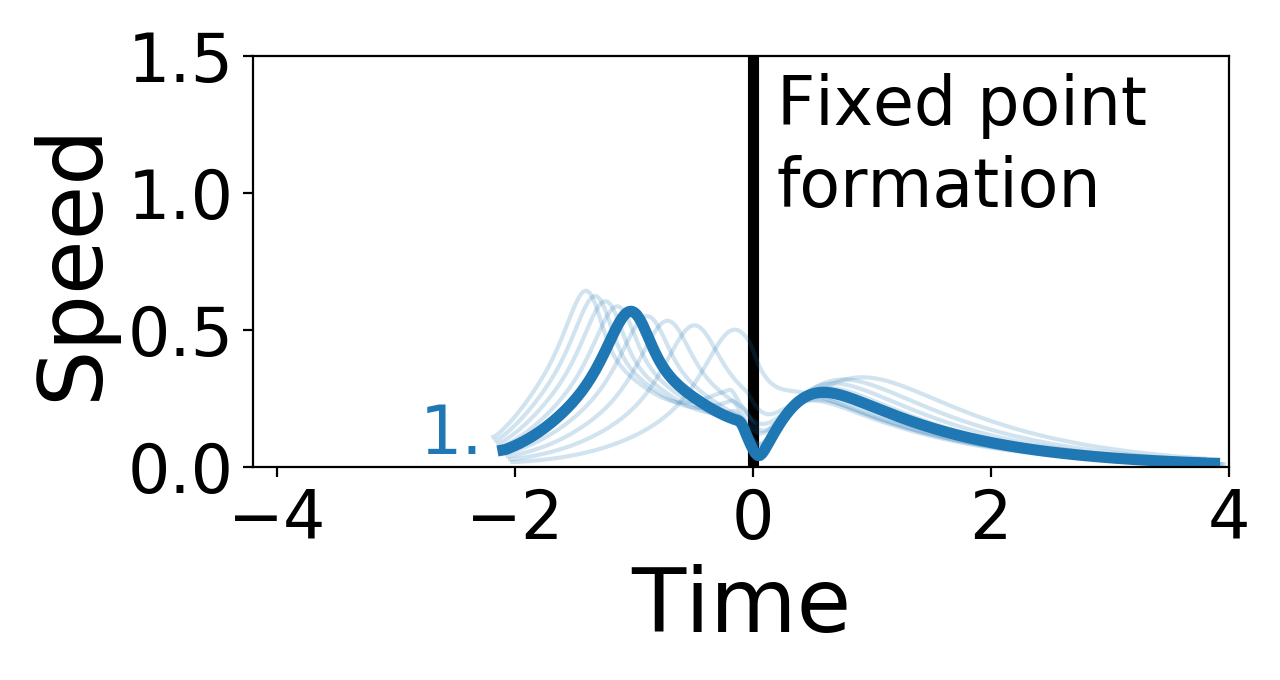

In [29]:
# Cells that end up in the first region of the pattern
plt.rcParams["figure.figsize"] = 6.4, 3.4
fig, ax = plt.subplots()


for k in range(pattern_boundaries[index_pattern_boundaries[-1,0]]+1, pattern_boundaries[index_pattern_boundaries[-1,1]]):
    
    # Compute the speed of cell k
    speed_gradient = np.gradient(results[k].transpose(), param["time_step"])[0].transpose()
    speed_gradient_modulus = np.sqrt(speed_gradient[0]*speed_gradient[0] +speed_gradient[1]*speed_gradient[1] +speed_gradient[2]*speed_gradient[2] +speed_gradient[3]*speed_gradient[3] +speed_gradient[4]*speed_gradient[4])   
    
    # Plot the speed of cell k
    if (k==cell_indices[0]):   
        ax.plot(times-times[cell_t_index_fp[k]], speed_gradient_modulus, c='tab:blue', lw=4, zorder=1)
       
    else:    
        ax.plot(times-times[cell_t_index_fp[k]], speed_gradient_modulus, c='tab:blue', alpha=0.2, zorder=1)

        
# Indicate the time at which the fixed point forms
ax.plot([0., 0.], [0, 1.5], lw=4, c='k', zorder=0)
ax.text(0.2, 1.25, 'Fixed point', fontsize=24)
ax.text(0.2, 0.95, 'formation', fontsize=24)

# Identify Cell 1
ax.text(-2.8, 0.05, '1.', color='tab:blue', fontsize=24)
   
# Other plot options
ax.set_xlabel('Time', fontsize=32)
ax.set_ylabel('Speed', fontsize=32)
ax.set_xlim([-4.2,4.])
ax.set_ylim([0.,1.5])
ax.set_xticks([-4., -2., 0., 2., 4.])
ax.set_yticks([0., 0.5, 1., 1.5])
ax.tick_params(labelsize=24)

fig.tight_layout()
fig.show()

<IPython.core.display.Javascript object>


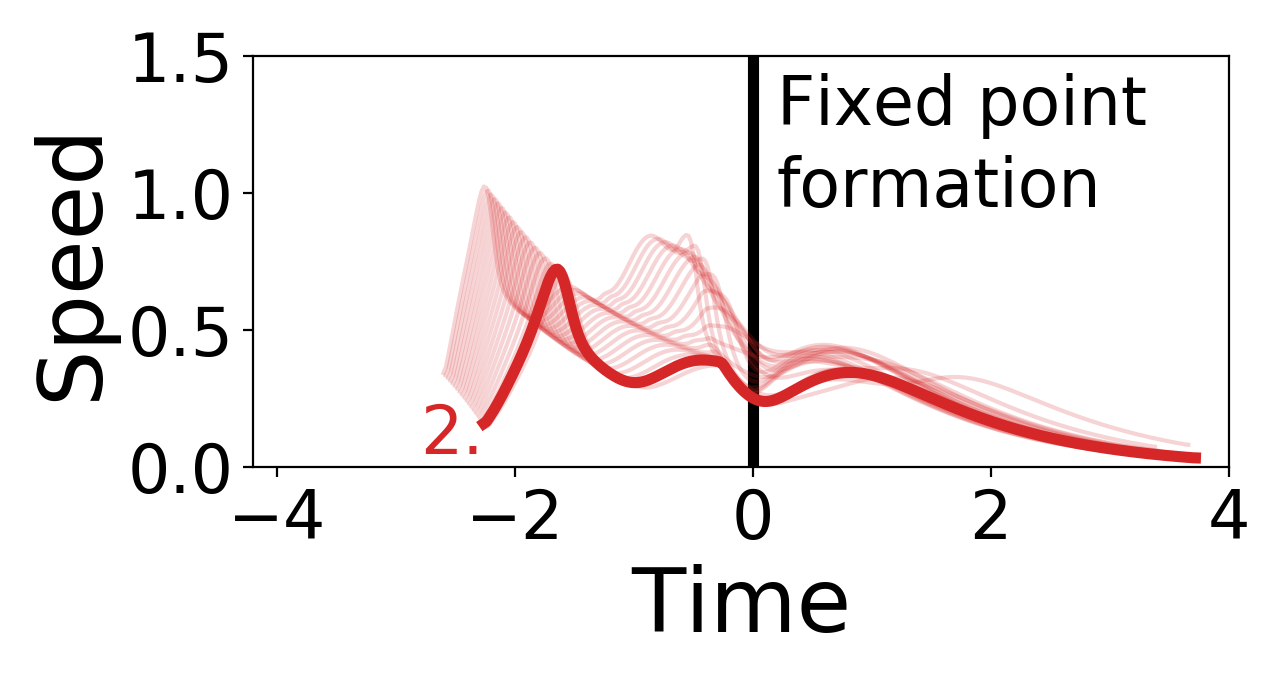

In [30]:
# Cells that end up with high [Kr] at the end of the simulation
plt.rcParams["figure.figsize"] = 6.4, 3.4
fig, ax = plt.subplots()


for k in range(pattern_boundaries[index_pattern_boundaries[-2,0]]+1, pattern_boundaries[index_pattern_boundaries[-2,1]]):
    
    # Compute the speed of cell k
    speed_gradient = np.gradient(results[k].transpose(), param["time_step"])[0].transpose()
    speed_gradient_modulus = np.sqrt(speed_gradient[0]*speed_gradient[0] +speed_gradient[1]*speed_gradient[1] +speed_gradient[2]*speed_gradient[2] +speed_gradient[3]*speed_gradient[3] +speed_gradient[4]*speed_gradient[4])   
    
    # Plot the speed of cell k
    if (k==cell_indices[1]):   
        ax.plot(times-times[cell_t_index_fp[k]], speed_gradient_modulus, c='tab:red', lw=4, zorder=1)
       
    else:    
        ax.plot(times-times[cell_t_index_fp[k]], speed_gradient_modulus, c='tab:red', alpha=0.2, zorder=1)

        
# Indicate the time at which the fixed point forms
ax.plot([0., 0.], [0, 1.5], lw=4, c='k', zorder=0)
ax.text(0.2, 1.25, 'Fixed point', fontsize=24)
ax.text(0.2, 0.95, 'formation', fontsize=24)

# Identify Cell 1
ax.text(-2.8, 0.05, '2.', color='tab:red', fontsize=24)
   
# Other plot options
ax.set_xlabel('Time', fontsize=32)
ax.set_ylabel('Speed', fontsize=32)
ax.set_xlim([-4.2,4.])
ax.set_ylim([0.,1.5])
ax.set_xticks([-4., -2., 0., 2., 4.])
ax.set_yticks([0., 0.5, 1., 1.5])
ax.tick_params(labelsize=24)

fig.tight_layout()
fig.show()

<IPython.core.display.Javascript object>


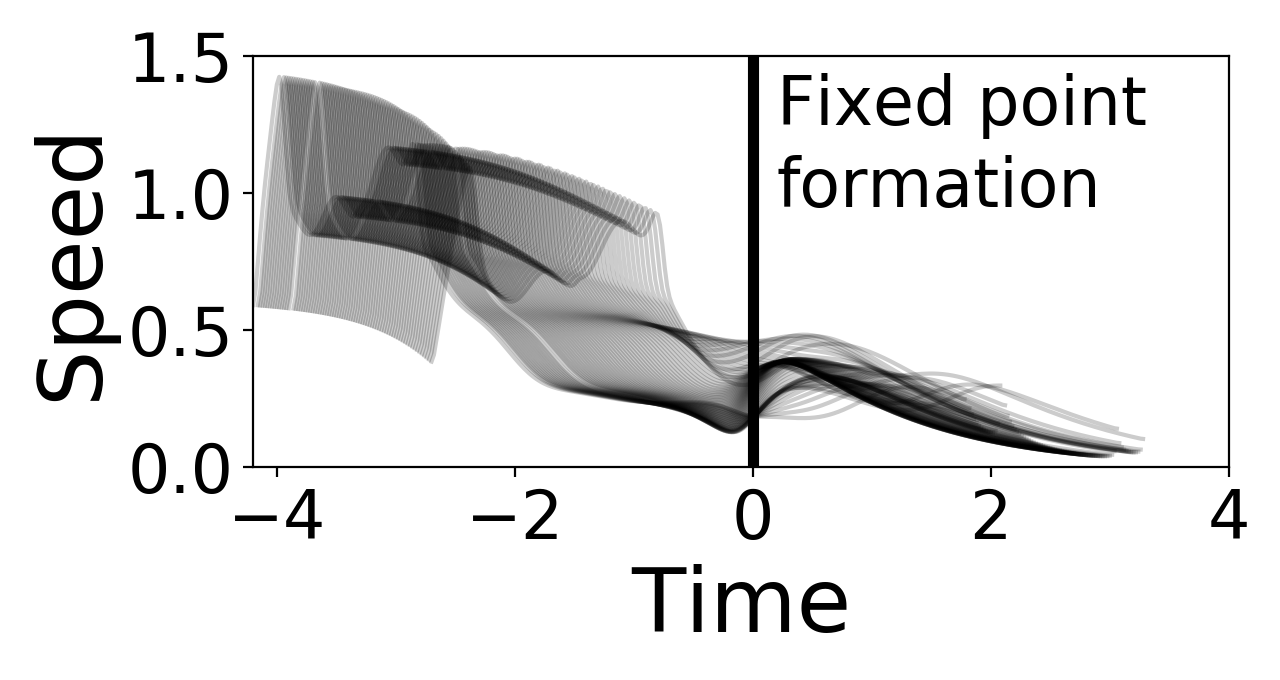

In [31]:
# Cells that end up with high [X] at the end of the simulation
plt.rcParams["figure.figsize"] = 6.4, 3.4
fig, ax = plt.subplots()


for k in range(pattern_boundaries[index_pattern_boundaries[0,0]]+1, pattern_boundaries[index_pattern_boundaries[0,1]]):
    
    # Compute the speed of cell k
    speed_gradient = np.gradient(results[k].transpose(), param["time_step"])[0].transpose()
    speed_gradient_modulus = np.sqrt(speed_gradient[0]*speed_gradient[0] +speed_gradient[1]*speed_gradient[1] +speed_gradient[2]*speed_gradient[2] +speed_gradient[3]*speed_gradient[3] +speed_gradient[4]*speed_gradient[4])   
    
    # Plot the speed of cell k
    ax.plot(times-times[cell_t_index_fp[k]], speed_gradient_modulus, c='k', alpha=0.2, zorder=1)

        
# Indicate the time at which the fixed point forms
ax.plot([0., 0.], [0, 1.5], lw=4, c='k', zorder=0)
ax.text(0.2, 1.25, 'Fixed point', fontsize=24)
ax.text(0.2, 0.95, 'formation', fontsize=24)
   
# Other plot options
ax.set_xlabel('Time', fontsize=32)
ax.set_ylabel('Speed', fontsize=32)
ax.set_xlim([-4.2,4.])
ax.set_ylim([0.,1.5])
ax.set_xticks([-4., -2., 0., 2., 4.])
ax.set_yticks([0., 0.5, 1., 1.5])
ax.tick_params(labelsize=24)

fig.tight_layout()
fig.show()